# Physics Constrained Autoencoders

By Mary Ye$^1$, Joshua C. Agar$^2$


$^1$ Department of Computer science and Engineering, Lehigh University
$^2$ Department of Mechanical Engineering and Mechanics, Drexel University

- There are many times where you want to fit spectroscopic data to a model


- Classical fitting methods can be used but break down:
  - When data is noisy
  - There are multiple candidate models
  - Data is high velocity
  - Data is noisy


## Imports Packages


In [1]:
!pip install m3_learning

In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import time
import math

from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn
from m3_learning.viz.layout import layout_fig, embedding_maps, latent_generator
from m3_learning.util.rand_util import rand_tensor, set_seeds

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

## Generating some data based on the image


### Define a non-linear function

<center> $$ y = A sin(2\theta f+ \phi)$$ </center>


In [3]:
class Sin_func:

    """
    Class that computes the Sin function
    """

    def __init__(
        self,
        x_vector,
        amp=[0, 1],
        phase=[0, 1],
        frequency=[0, 1],
        size=(1, 1),
        batch_size=1000,
        verbose=False,
    ):
        """

        Args:
            x_vector:
            sd (array, float): range for the standard deviation
            mean (array, float): range for the mean
            amp (array, float): range for the amplitude
            size (tuple): Size of the array first index is number of channels, second is number of functions
            verbose (bool): shows outputs
        """

        self.x_vector = x_vector
        self.batch_size = batch_size

        self.amp = amp
        self.amp_mean = torch.tensor(amp[0] + amp[1]) / 2
        self.amp_sd = torch.sqrt(
            torch.pow(torch.tensor(amp[1]) - torch.tensor(amp[0]), 2) / 12
        )

        self.phase = phase
        self.phase_mean = torch.tensor(phase[0] + phase[1]) / 2
        self.phase_sd = torch.sqrt(
            torch.pow(torch.tensor(phase[1]) - torch.tensor(phase[0]), 2) / 12
        )

        self.frequency = frequency
        self.frequency_mean = torch.tensor(frequency[0] + frequency[1]) / 2
        self.frequency_sd = torch.sqrt(
            torch.pow(torch.tensor(frequency[1]) - torch.tensor(frequency[0]), 2) / 12
        )

        self.size = size
        self.verbose = verbose

    def compute(self, params, device="cpu"):
        """

        Args:
            self (object): Returns the instance itself.
            device (string, optional) : Sets the device to do the computation. Default `cpu`, common option `cuda`

        Returns: out (Tensor): spectra.

        """

        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros(
            (params.shape[0], self.x_vector.shape[0], self.size[0], self.size[1])
        )

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _amp = params[:, 0, 0, i]
                _phase = params[:, 0, 1, i]
                _frequency = params[:, 0, 2, i]

            if params.ndim == 3:
                _amp = params[:, 0, i]
                _phase = params[:, 1, i]
                _frequency = params[:, 2, i]

            x_vector = (
                torch.cat(params.shape[0] * [self.x_vector])
                .reshape(params.shape[0], -1)
                .to(device)
            )
            x_vector = torch.transpose(x_vector, 0, 1)  # .to(device)

            _out = _amp * torch.sin(
                2 * torch.tensor(np.pi) * _frequency * x_vector + _phase
            )

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)

    def sampler(self, device="cpu"):
        """

        Args:
            device (str): device where computation happens

        Returns:
            out (Tensor) : Generated spectra
            params (Tensor) : parameters used for generation

        """

        phase = rand_tensor(
            min=self.phase[0],
            max=self.phase[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        frequency = rand_tensor(
            min=self.frequency[0],
            max=self.frequency[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        amp = rand_tensor(
            min=self.amp[0],
            max=self.amp[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        _params = torch.torch.stack((amp, phase, frequency))

        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)

        return (self.compute(_params, device=device), _params)

In [4]:
constructor = Sin_func(
    amp=[0.2, 1],  # Sets the amplitude
    phase=[0, 2 * np.pi],  # Sets the phase
    frequency=[0.1, 0.5],  # Sets the frequency
    x_vector=torch.linspace(0, np.pi, 100),  # Sets the x_vector
    batch_size=10000,
)  # number of samples to generate

In [5]:
# initializes the constructor
output = constructor.sampler()

# grabs the parameters and the spectra
spectra, params = output

# This grabs the sum of all spectral and the individual spectra if they exist
spectra_full, spectras = spectra

## Visualize examples


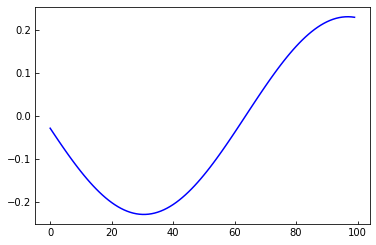

In [6]:
rand = np.random.randint(0, 10000)
plt.plot(spectras[rand, :, 0].cpu(), "b")


## Recurrent Neural Network Autoencoders

- It is important to consider the temporal domain
- This can be improved by using a recurrent neural network that processes each time step sequentially.
- To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.


![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/Autoencoder_Med.png?raw=true)


![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/LSTM%20Node.png?raw=true)


### Builds the autoencoder


In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 100, 1])
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [8]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):

        # encode

        embedding = self.encoder(x)

        # decode

        predicted = self.decoder(embedding)

        return predicted


Since we know there are intrinsically 3 latent dimensions let's try and train the model.


In [9]:
device = "cuda"
latent_dim = 3

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [10]:
# views the model

model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Builds the dataloader


In [11]:
# constructs a dataloader for training

dataloader = DataLoader(spectra_full, batch_size=512, shuffle=True, num_workers=0)


In [12]:
# trains the model

torch.manual_seed(0)
Train(
    model, encoder, decoder, dataloader, optimizer, 500,
)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  5%|████▏                                                                              | 1/20 [00:01<00:26,  1.38s/it]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  8.14it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:01<00:00, 17.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.37it/s]

Epoch 0, Train Loss: 0.2125
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.21it/s]

Epoch 1, Train Loss: 0.2108
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.21it/s]

Epoch 2, Train Loss: 0.2095
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.64it/s]

Epoch 3, Train Loss: 0.2087
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 4, Train Loss: 0.2085
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 5, Train Loss: 0.2073
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.01it/s]

Epoch 6, Train Loss: 0.2073
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 7, Train Loss: 0.2065
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 8, Train Loss: 0.2064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 9, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.49it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.64it/s]

Epoch 10, Train Loss: 0.2064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 11, Train Loss: 0.2057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.32it/s]

Epoch 12, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 13, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 14, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.74it/s]

Epoch 15, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 16, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 17, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.83it/s]

Epoch 18, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 19, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 20, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 21, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 22, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 23, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 24, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 25, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 26, Train Loss: 0.2058
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 27, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.38it/s]

Epoch 28, Train Loss: 0.2050
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 29, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 30, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.10it/s]

Epoch 31, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.65it/s]

Epoch 32, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.34it/s]

Epoch 33, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 34, Train Loss: 0.2058
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.50it/s]

Epoch 35, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.38it/s]

Epoch 36, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 37, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 38, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.65it/s]

Epoch 39, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 40, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.33it/s]

Epoch 41, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.27it/s]

Epoch 42, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.73it/s]

Epoch 43, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 44, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|████████████████████████████████████████▌                                        | 10/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.78it/s]

Epoch 45, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.32it/s]

Epoch 46, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 47, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 48, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 49, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 50, Train Loss: 0.2051
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.49it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.92it/s]

Epoch 51, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.20it/s]

Epoch 52, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 53, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 54, Train Loss: 0.2048
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.12it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.70it/s]

Epoch 55, Train Loss: 0.2045
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.88it/s]

Epoch 56, Train Loss: 0.2045
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.97it/s]

Epoch 57, Train Loss: 0.2048
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 58, Train Loss: 0.2048
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 59, Train Loss: 0.2042
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 60, Train Loss: 0.2038
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 61, Train Loss: 0.2034
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 79.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.96it/s]

Epoch 62, Train Loss: 0.2029
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 63, Train Loss: 0.2026
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.15it/s]

Epoch 64, Train Loss: 0.2019
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 79.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.63it/s]

Epoch 65, Train Loss: 0.2012
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

Epoch 66, Train Loss: 0.2006
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 67, Train Loss: 0.2001
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 78.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.63it/s]

Epoch 68, Train Loss: 0.1989
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 69, Train Loss: 0.1990
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.23it/s]

Epoch 70, Train Loss: 0.1977
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.50it/s]

Epoch 71, Train Loss: 0.1976
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 72, Train Loss: 0.1975
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.74it/s]

Epoch 73, Train Loss: 0.1968
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 74, Train Loss: 0.1961
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 80.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.47it/s]

Epoch 75, Train Loss: 0.1958
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 76, Train Loss: 0.1953
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.20it/s]

Epoch 77, Train Loss: 0.1950
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.64it/s]

Epoch 78, Train Loss: 0.1948
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.38it/s]

Epoch 79, Train Loss: 0.1941
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 80, Train Loss: 0.1942
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 81, Train Loss: 0.1939
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.64it/s]

Epoch 82, Train Loss: 0.1940
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 83, Train Loss: 0.1937
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.46it/s]

Epoch 84, Train Loss: 0.1938
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 85, Train Loss: 0.1936
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.46it/s]

Epoch 86, Train Loss: 0.1936
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.96it/s]

Epoch 87, Train Loss: 0.1933
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 88, Train Loss: 0.1928
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.50it/s]

Epoch 89, Train Loss: 0.1932
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

Epoch 90, Train Loss: 0.1929
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.70it/s]

Epoch 91, Train Loss: 0.1927
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 92, Train Loss: 0.1929
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 93, Train Loss: 0.1932
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 94, Train Loss: 0.1928
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 95, Train Loss: 0.1926
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 96, Train Loss: 0.1922
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 97, Train Loss: 0.1924
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.96it/s]

Epoch 98, Train Loss: 0.1921
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.46it/s]

Epoch 99, Train Loss: 0.1922
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 100, Train Loss: 0.1919
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 79.21it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 84.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 101, Train Loss: 0.1918
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 80.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.50it/s]

Epoch 102, Train Loss: 0.1912
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 103, Train Loss: 0.1912
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.08it/s]

Epoch 104, Train Loss: 0.1914
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 105, Train Loss: 0.1907
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.49it/s]

Epoch 106, Train Loss: 0.1907
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

Epoch 107, Train Loss: 0.1904
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 108, Train Loss: 0.1902
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 109, Train Loss: 0.1899
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.05it/s]

Epoch 110, Train Loss: 0.1900
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 111, Train Loss: 0.1897
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 112, Train Loss: 0.1897
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 113, Train Loss: 0.1896
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.57it/s]

Epoch 114, Train Loss: 0.1892
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 115, Train Loss: 0.1891
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 116, Train Loss: 0.1888
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.90it/s]

Epoch 117, Train Loss: 0.1887
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 87.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 85.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.38it/s]

Epoch 118, Train Loss: 0.1892
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.11it/s]

Epoch 119, Train Loss: 0.1890
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 88.49it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 87.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 120, Train Loss: 0.1888
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.70it/s]

Epoch 121, Train Loss: 0.1889
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 122, Train Loss: 0.1890
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 123, Train Loss: 0.1889
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 124, Train Loss: 0.1881
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 125, Train Loss: 0.1885
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.96it/s]

Epoch 126, Train Loss: 0.1881
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 127, Train Loss: 0.1884
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 128, Train Loss: 0.1879
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 129, Train Loss: 0.1886
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 130, Train Loss: 0.1880
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 131, Train Loss: 0.1885
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.69it/s]

Epoch 132, Train Loss: 0.1883
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 133, Train Loss: 0.1880
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 134, Train Loss: 0.1879
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.78it/s]

Epoch 135, Train Loss: 0.1876
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 65.02it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 75.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 76.34it/s]

Epoch 136, Train Loss: 0.1878
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 137, Train Loss: 0.1880
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 138, Train Loss: 0.1877
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.27it/s]

Epoch 139, Train Loss: 0.1878
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 140, Train Loss: 0.1877
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.93it/s]

Epoch 141, Train Loss: 0.1875
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.28it/s]

Epoch 142, Train Loss: 0.1878
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 143, Train Loss: 0.1877
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 88.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.68it/s]

Epoch 144, Train Loss: 0.1872
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 145, Train Loss: 0.1880
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.30it/s]

Epoch 146, Train Loss: 0.1878
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 147, Train Loss: 0.1875
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 148, Train Loss: 0.1875
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.50it/s]

Epoch 149, Train Loss: 0.1872
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.52it/s]

Epoch 150, Train Loss: 0.1867
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 151, Train Loss: 0.1874
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 152, Train Loss: 0.1872
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.08it/s]

Epoch 153, Train Loss: 0.1873
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 154, Train Loss: 0.1875
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.10it/s]

Epoch 155, Train Loss: 0.1866
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.44it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.80it/s]

Epoch 156, Train Loss: 0.1874
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.23it/s]

Epoch 157, Train Loss: 0.1874
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.96it/s]

Epoch 158, Train Loss: 0.1869
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]

Epoch 159, Train Loss: 0.1874
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 160, Train Loss: 0.1869
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 161, Train Loss: 0.1864
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 87.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 162, Train Loss: 0.1867
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 163, Train Loss: 0.1868
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

Epoch 164, Train Loss: 0.1865
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.90it/s]

Epoch 165, Train Loss: 0.1868
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 166, Train Loss: 0.1866
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

Epoch 167, Train Loss: 0.1868
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 168, Train Loss: 0.1863
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.98it/s]

Epoch 169, Train Loss: 0.1867
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 78.44it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:00<00:00, 78.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 77.66it/s]

Epoch 170, Train Loss: 0.1862
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.30it/s]

Epoch 171, Train Loss: 0.1862
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 172, Train Loss: 0.1861
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 173, Train Loss: 0.1858
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.29it/s]

Epoch 174, Train Loss: 0.1856
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.10it/s]

Epoch 175, Train Loss: 0.1857
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.13it/s]

Epoch 176, Train Loss: 0.1859
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 76.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 79.05it/s]

Epoch 177, Train Loss: 0.1851
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 178, Train Loss: 0.1853
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]

Epoch 179, Train Loss: 0.1852
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 180, Train Loss: 0.1850
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 181, Train Loss: 0.1845
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 182, Train Loss: 0.1839
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.23it/s]

Epoch 183, Train Loss: 0.1832
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 184, Train Loss: 0.1825
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 185, Train Loss: 0.1810
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 186, Train Loss: 0.1796
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 187, Train Loss: 0.1768
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.81it/s]

Epoch 188, Train Loss: 0.1728
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 189, Train Loss: 0.1676
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 190, Train Loss: 0.1642
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.31it/s]

Epoch 191, Train Loss: 0.1620
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.35it/s]

Epoch 192, Train Loss: 0.1603
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.96it/s]

Epoch 193, Train Loss: 0.1592
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.49it/s]

Epoch 194, Train Loss: 0.1585
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 195, Train Loss: 0.1575
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 196, Train Loss: 0.1567
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 197, Train Loss: 0.1561
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 35%|█████████████████████████████                                                      | 7/20 [00:00<00:00, 69.99it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:00<00:00, 58.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 59.34it/s]

Epoch 198, Train Loss: 0.1551
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.58it/s]

Epoch 199, Train Loss: 0.1548
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.71it/s]

Epoch 200, Train Loss: 0.1542
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 90.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.68it/s]

Epoch 201, Train Loss: 0.1537
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.98it/s]

Epoch 202, Train Loss: 0.1530
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.97it/s]

Epoch 203, Train Loss: 0.1526
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.77it/s]

Epoch 204, Train Loss: 0.1515
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.81it/s]

Epoch 205, Train Loss: 0.1509
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.58it/s]

Epoch 206, Train Loss: 0.1504
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.58it/s]

Epoch 207, Train Loss: 0.1497
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.58it/s]

Epoch 208, Train Loss: 0.1489
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.82it/s]

Epoch 209, Train Loss: 0.1481
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 210, Train Loss: 0.1474
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.46it/s]

Epoch 211, Train Loss: 0.1468
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 212, Train Loss: 0.1463
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.22it/s]

Epoch 213, Train Loss: 0.1452
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.58it/s]

Epoch 214, Train Loss: 0.1451
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 88.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.89it/s]

Epoch 215, Train Loss: 0.1444
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.01it/s]

Epoch 216, Train Loss: 0.1437
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.95it/s]

Epoch 217, Train Loss: 0.1433
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 88.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.50it/s]

Epoch 218, Train Loss: 0.1429
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.32it/s]

Epoch 219, Train Loss: 0.1425
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.05it/s]

Epoch 220, Train Loss: 0.1420
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.06it/s]

Epoch 221, Train Loss: 0.1417
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.59it/s]

Epoch 222, Train Loss: 0.1413
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.40it/s]

Epoch 223, Train Loss: 0.1411
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.34it/s]

Epoch 224, Train Loss: 0.1406
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 88.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 86.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.40it/s]

Epoch 225, Train Loss: 0.1405
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.59it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.24it/s]

Epoch 226, Train Loss: 0.1403
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.75it/s]

Epoch 227, Train Loss: 0.1394
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.17it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 57.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 61.75it/s]

Epoch 228, Train Loss: 0.1392
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 35%|█████████████████████████████                                                      | 7/20 [00:00<00:00, 57.91it/s]

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:00<00:00, 45.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 45.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 45.52it/s]

Epoch 229, Train Loss: 0.1390
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 4/20 [00:00<00:00, 38.08it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 44.47it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:00<00:00, 38.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 39.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 39.08it/s]

Epoch 230, Train Loss: 0.1395
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 30%|████████████████████████▉                                                          | 6/20 [00:00<00:00, 48.88it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 46.63it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:00<00:00, 44.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 50.12it/s]

Epoch 231, Train Loss: 0.1393
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.14it/s]

Epoch 232, Train Loss: 0.1385
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.68it/s]

Epoch 233, Train Loss: 0.1390
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.36it/s]

Epoch 234, Train Loss: 0.1379
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.79it/s]

Epoch 235, Train Loss: 0.1381
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 88.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.31it/s]

Epoch 236, Train Loss: 0.1377
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.51it/s]

Epoch 237, Train Loss: 0.1372
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.17it/s]

Epoch 238, Train Loss: 0.1373
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.97it/s]

Epoch 239, Train Loss: 0.1371
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.09it/s]

Epoch 240, Train Loss: 0.1368
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.78it/s]

Epoch 241, Train Loss: 0.1368
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.63it/s]

Epoch 242, Train Loss: 0.1366
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.15it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.07it/s]

Epoch 243, Train Loss: 0.1366
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.20it/s]

Epoch 244, Train Loss: 0.1360
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.72it/s]

Epoch 245, Train Loss: 0.1364
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.74it/s]

Epoch 246, Train Loss: 0.1365
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 86.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.99it/s]

Epoch 247, Train Loss: 0.1356
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.07it/s]

Epoch 248, Train Loss: 0.1358
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.15it/s]

Epoch 249, Train Loss: 0.1355
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.14it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.62it/s]

Epoch 250, Train Loss: 0.1351
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.95it/s]

Epoch 251, Train Loss: 0.1355
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.55it/s]

Epoch 252, Train Loss: 0.1344
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.40it/s]

Epoch 253, Train Loss: 0.1342
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.44it/s]

Epoch 254, Train Loss: 0.1340
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.01it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.71it/s]

Epoch 255, Train Loss: 0.1340
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.18it/s]

Epoch 256, Train Loss: 0.1336
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.49it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.32it/s]

Epoch 257, Train Loss: 0.1335
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.57it/s]

Epoch 258, Train Loss: 0.1333
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 77.97it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:00<00:00, 76.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 77.18it/s]

Epoch 259, Train Loss: 0.1329
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 77.67it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:00<00:00, 78.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 77.52it/s]

Epoch 260, Train Loss: 0.1326
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 79.96it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 76.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 77.35it/s]

Epoch 261, Train Loss: 0.1323
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 80.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 77.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 78.73it/s]

Epoch 262, Train Loss: 0.1322
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.74it/s]

Epoch 263, Train Loss: 0.1320
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.08it/s]

Epoch 264, Train Loss: 0.1321
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.97it/s]

Epoch 265, Train Loss: 0.1311
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.16it/s]

Epoch 266, Train Loss: 0.1309
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 267, Train Loss: 0.1301
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 86.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 268, Train Loss: 0.1297
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.57it/s]

Epoch 269, Train Loss: 0.1292
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.87it/s]

Epoch 270, Train Loss: 0.1286
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.10it/s]

Epoch 271, Train Loss: 0.1275
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.21it/s]

Epoch 272, Train Loss: 0.1270
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.83it/s]

Epoch 273, Train Loss: 0.1262
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.09it/s]

Epoch 274, Train Loss: 0.1261
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.88it/s]

Epoch 275, Train Loss: 0.1250
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.85it/s]

Epoch 276, Train Loss: 0.1249
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.21it/s]

Epoch 277, Train Loss: 0.1242
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.10it/s]

Epoch 278, Train Loss: 0.1237
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.26it/s]

Epoch 279, Train Loss: 0.1230
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.57it/s]

Epoch 280, Train Loss: 0.1227
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.33it/s]

Epoch 281, Train Loss: 0.1218
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.59it/s]

Epoch 282, Train Loss: 0.1214
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.10it/s]

Epoch 283, Train Loss: 0.1211
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.33it/s]

Epoch 284, Train Loss: 0.1205
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.57it/s]

Epoch 285, Train Loss: 0.1197
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.38it/s]

Epoch 286, Train Loss: 0.1195
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.56it/s]

Epoch 287, Train Loss: 0.1195
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 288, Train Loss: 0.1188
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.55it/s]

Epoch 289, Train Loss: 0.1185
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.97it/s]

Epoch 290, Train Loss: 0.1178
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.94it/s]

Epoch 291, Train Loss: 0.1175
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.67it/s]

Epoch 292, Train Loss: 0.1181
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.75it/s]

Epoch 293, Train Loss: 0.1176
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.33it/s]

Epoch 294, Train Loss: 0.1175
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

Epoch 295, Train Loss: 0.1162
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 296, Train Loss: 0.1162
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.81it/s]

Epoch 297, Train Loss: 0.1156
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.02it/s]

Epoch 298, Train Loss: 0.1160
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.41it/s]

Epoch 299, Train Loss: 0.1158
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 300, Train Loss: 0.1154
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.48it/s]

Epoch 301, Train Loss: 0.1155
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.38it/s]

Epoch 302, Train Loss: 0.1144
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.82it/s]

Epoch 303, Train Loss: 0.1142
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.40it/s]

Epoch 304, Train Loss: 0.1139
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 305, Train Loss: 0.1136
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.45it/s]

Epoch 306, Train Loss: 0.1135
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.55it/s]

Epoch 307, Train Loss: 0.1136
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 308, Train Loss: 0.1135
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.93it/s]

Epoch 309, Train Loss: 0.1127
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.53it/s]

Epoch 310, Train Loss: 0.1125
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.58it/s]

Epoch 311, Train Loss: 0.1125
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.13it/s]

Epoch 312, Train Loss: 0.1120
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.19it/s]

Epoch 313, Train Loss: 0.1121
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.33it/s]

Epoch 314, Train Loss: 0.1120
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.43it/s]

Epoch 315, Train Loss: 0.1120
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.06it/s]

Epoch 316, Train Loss: 0.1117
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.10it/s]

Epoch 317, Train Loss: 0.1113
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 318, Train Loss: 0.1114
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.21it/s]

Epoch 319, Train Loss: 0.1112
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.94it/s]

Epoch 320, Train Loss: 0.1105
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 88.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 84.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.04it/s]

Epoch 321, Train Loss: 0.1107
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 77.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 79.52it/s]

Epoch 322, Train Loss: 0.1104
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 323, Train Loss: 0.1107
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 324, Train Loss: 0.1110
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.23it/s]

Epoch 325, Train Loss: 0.1100
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.25it/s]

Epoch 326, Train Loss: 0.1098
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 327, Train Loss: 0.1098
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.50it/s]

Epoch 328, Train Loss: 0.1094
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 329, Train Loss: 0.1094
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 89.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.68it/s]

Epoch 330, Train Loss: 0.1093
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 331, Train Loss: 0.1086
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 332, Train Loss: 0.1088
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 333, Train Loss: 0.1090
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 334, Train Loss: 0.1086
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.50it/s]

Epoch 335, Train Loss: 0.1085
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 336, Train Loss: 0.1081
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.33it/s]

Epoch 337, Train Loss: 0.1082
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.89it/s]

Epoch 338, Train Loss: 0.1081
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 339, Train Loss: 0.1085
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.37it/s]

Epoch 340, Train Loss: 0.1078
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 341, Train Loss: 0.1079
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 342, Train Loss: 0.1073
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.47it/s]

Epoch 343, Train Loss: 0.1072
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 344, Train Loss: 0.1072
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.54it/s]

Epoch 345, Train Loss: 0.1072
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.50it/s]

Epoch 346, Train Loss: 0.1069
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.29it/s]

Epoch 347, Train Loss: 0.1068
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 348, Train Loss: 0.1067
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.79it/s]

Epoch 349, Train Loss: 0.1066
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 89.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 350, Train Loss: 0.1068
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 351, Train Loss: 0.1064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.21it/s]

Epoch 352, Train Loss: 0.1062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.46it/s]

Epoch 353, Train Loss: 0.1065
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.46it/s]

Epoch 354, Train Loss: 0.1061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 355, Train Loss: 0.1063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.65it/s]

Epoch 356, Train Loss: 0.1059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.97it/s]

Epoch 357, Train Loss: 0.1060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 358, Train Loss: 0.1063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.44it/s]

Epoch 359, Train Loss: 0.1062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 360, Train Loss: 0.1054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.49it/s]

Epoch 361, Train Loss: 0.1055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 362, Train Loss: 0.1056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.46it/s]

Epoch 363, Train Loss: 0.1052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

Epoch 364, Train Loss: 0.1052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 365, Train Loss: 0.1048
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 366, Train Loss: 0.1051
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 367, Train Loss: 0.1048
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 368, Train Loss: 0.1045
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 369, Train Loss: 0.1044
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 370, Train Loss: 0.1044
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 371, Train Loss: 0.1045
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 372, Train Loss: 0.1043
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.48it/s]

Epoch 373, Train Loss: 0.1043
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 374, Train Loss: 0.1042
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 375, Train Loss: 0.1043
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.11it/s]

Epoch 376, Train Loss: 0.1040
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.91it/s]

Epoch 377, Train Loss: 0.1041
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.11it/s]

Epoch 378, Train Loss: 0.1042
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.03it/s]

Epoch 379, Train Loss: 0.1037
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 380, Train Loss: 0.1040
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.79it/s]

Epoch 381, Train Loss: 0.1046
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.38it/s]

Epoch 382, Train Loss: 0.1043
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 383, Train Loss: 0.1041
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.88it/s]

Epoch 384, Train Loss: 0.1036
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 78.70it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 63.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 66.28it/s]

Epoch 385, Train Loss: 0.1035
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 79.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.83it/s]

Epoch 386, Train Loss: 0.1034
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.79it/s]

Epoch 387, Train Loss: 0.1033
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.64it/s]

Epoch 388, Train Loss: 0.1032
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 389, Train Loss: 0.1030
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.64it/s]

Epoch 390, Train Loss: 0.1031
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.10it/s]

Epoch 391, Train Loss: 0.1029
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 392, Train Loss: 0.1032
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 393, Train Loss: 0.1031
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 394, Train Loss: 0.1029
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.63it/s]

Epoch 395, Train Loss: 0.1027
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.67it/s]

Epoch 396, Train Loss: 0.1027
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.63it/s]

Epoch 397, Train Loss: 0.1025
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]

Epoch 398, Train Loss: 0.1025
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 399, Train Loss: 0.1026
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 400, Train Loss: 0.1028
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 401, Train Loss: 0.1026
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.29it/s]

Epoch 402, Train Loss: 0.1023
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 403, Train Loss: 0.1024
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 404, Train Loss: 0.1024
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.55it/s]

Epoch 405, Train Loss: 0.1023
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

Epoch 406, Train Loss: 0.1023
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.88it/s]

Epoch 407, Train Loss: 0.1022
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 408, Train Loss: 0.1019
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.29it/s]

Epoch 409, Train Loss: 0.1022
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.65it/s]

Epoch 410, Train Loss: 0.1016
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.97it/s]

Epoch 411, Train Loss: 0.1022
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.96it/s]

Epoch 412, Train Loss: 0.1020
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.97it/s]

Epoch 413, Train Loss: 0.1015
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.47it/s]

Epoch 414, Train Loss: 0.1017
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 415, Train Loss: 0.1015
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.12it/s]

Epoch 416, Train Loss: 0.1015
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 417, Train Loss: 0.1016
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]

Epoch 418, Train Loss: 0.1015
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 419, Train Loss: 0.1018
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 420, Train Loss: 0.1013
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 421, Train Loss: 0.1012
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 422, Train Loss: 0.1012
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.21it/s]

Epoch 423, Train Loss: 0.1011
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.63it/s]

Epoch 424, Train Loss: 0.1010
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 425, Train Loss: 0.1010
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.16it/s]

Epoch 426, Train Loss: 0.1011
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.98it/s]

Epoch 427, Train Loss: 0.1011
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 428, Train Loss: 0.1010
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 429, Train Loss: 0.1006
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]

Epoch 430, Train Loss: 0.1006
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.47it/s]

Epoch 431, Train Loss: 0.1009
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.97it/s]

Epoch 432, Train Loss: 0.1007
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.64it/s]

Epoch 433, Train Loss: 0.1006
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.97it/s]

Epoch 434, Train Loss: 0.1005
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 435, Train Loss: 0.1007
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.00it/s]

Epoch 436, Train Loss: 0.1006
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

Epoch 437, Train Loss: 0.1003
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.61it/s]

Epoch 438, Train Loss: 0.1006
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.05it/s]

Epoch 439, Train Loss: 0.1007
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.83it/s]

Epoch 440, Train Loss: 0.1002
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 441, Train Loss: 0.1004
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 442, Train Loss: 0.1001
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 443, Train Loss: 0.1002
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 444, Train Loss: 0.1003
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.28it/s]

Epoch 445, Train Loss: 0.1000
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 446, Train Loss: 0.0999
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 447, Train Loss: 0.0997
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.33it/s]

Epoch 448, Train Loss: 0.0998
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.58it/s]

Epoch 449, Train Loss: 0.0998
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.62it/s]

Epoch 450, Train Loss: 0.0998
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.28it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 87.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.10it/s]

Epoch 451, Train Loss: 0.1000
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 452, Train Loss: 0.0998
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 453, Train Loss: 0.0995
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.37it/s]

Epoch 454, Train Loss: 0.0997
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.29it/s]

Epoch 455, Train Loss: 0.0997
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 456, Train Loss: 0.0996
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.28it/s]

Epoch 457, Train Loss: 0.0995
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.50it/s]

Epoch 458, Train Loss: 0.0994
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.93it/s]

Epoch 459, Train Loss: 0.0993
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 460, Train Loss: 0.0996
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.29it/s]

Epoch 461, Train Loss: 0.0991
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.49it/s]

Epoch 462, Train Loss: 0.0992
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.19it/s]

Epoch 463, Train Loss: 0.0989
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.90it/s]

Epoch 464, Train Loss: 0.0989
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 84.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 465, Train Loss: 0.0991
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.83it/s]

Epoch 466, Train Loss: 0.0989
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 467, Train Loss: 0.0992
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 468, Train Loss: 0.0995
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

Epoch 469, Train Loss: 0.0987
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

Epoch 470, Train Loss: 0.0990
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 471, Train Loss: 0.0989
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.15it/s]

Epoch 472, Train Loss: 0.0989
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 473, Train Loss: 0.0988
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.21it/s]

Epoch 474, Train Loss: 0.0985
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 475, Train Loss: 0.0986
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 476, Train Loss: 0.0986
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.57it/s]

Epoch 477, Train Loss: 0.0988
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.11it/s]

Epoch 478, Train Loss: 0.0987
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

Epoch 479, Train Loss: 0.0985
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 480, Train Loss: 0.0990
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 481, Train Loss: 0.0984
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.01it/s]

Epoch 482, Train Loss: 0.0981
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.32it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.93it/s]

Epoch 483, Train Loss: 0.0983
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.96it/s]

Epoch 484, Train Loss: 0.0984
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.58it/s]

Epoch 485, Train Loss: 0.0983
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.89it/s]

Epoch 486, Train Loss: 0.0979
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 487, Train Loss: 0.0980
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.63it/s]

Epoch 488, Train Loss: 0.0980
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 489, Train Loss: 0.0980
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.76it/s]

Epoch 490, Train Loss: 0.0984
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 491, Train Loss: 0.0982
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 492, Train Loss: 0.0976
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 493, Train Loss: 0.0979
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 494, Train Loss: 0.0979
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.28it/s]

Epoch 495, Train Loss: 0.0979
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 496, Train Loss: 0.0977
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 497, Train Loss: 0.0977
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.29it/s]

Epoch 498, Train Loss: 0.0975
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.50it/s]

Epoch 499, Train Loss: 0.0976
.............................


In [13]:
# # functions used to grab embbedings and predictions


# def transform_nn(data, encoder, decoder):

#     encoded_spectra = encoder(torch.tensor(np.atleast_3d(data),
#                               dtype=torch.float32).to(device))

#     decoded_spectra = decoder(encoded_spectra)

#     encoded_spectra = encoded_spectra.to('cpu')
#     encoded_spectra = encoded_spectra.detach().numpy()
#     decoded_spectra = decoded_spectra.to('cpu')
#     decoded_spectra = decoded_spectra.detach().numpy()
#     return (encoded_spectra, decoded_spectra)

## Visualize the reconstruction


In [14]:
# computes an example reconstruction for a mini batch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)


C:\Conda\lib\site-packages\m3_learning\nn\time_series_nn\nn_util.py:294: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_spectra = encoder(torch.tensor(data, dtype=torch.float32).to(device))


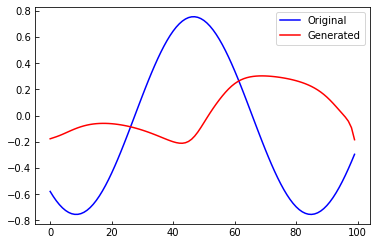

In [15]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


## Generating Validation Data

- We want to generate a hyperspectral image
- This can be done by taking the RGB values of an image and using them as parameters for a function


### Loads and image of my dog Nala

- Painting by _Irene Dogmatic_


In [16]:
# Loads dog image

image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image

image = image[200:1900:20, 100:1500:20] / 255

### Displays the image


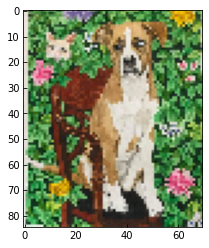

In [17]:
plt.imshow(image)

### Generates the data from RGB sampling


In [18]:
# Converts the image into parameters within the generated range

nala_params = np.atleast_3d(image.reshape(-1, 3))

nala_amp = torch.tensor(nala_params[:, 0, 0] * 0.8 + 0.2)
nala_phase = torch.tensor(nala_params[:, 1, 0] * 2 * np.pi)
nala_frequency = torch.tensor(nala_params[:, 2, 0] * 0.5 + 0.1)

_nala_params = torch.torch.stack((nala_amp, nala_phase, nala_frequency))

_nala_params = torch.atleast_3d(_nala_params)
_nala_params = torch.transpose(_nala_params, 0, 1)


In [19]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder, decoder)


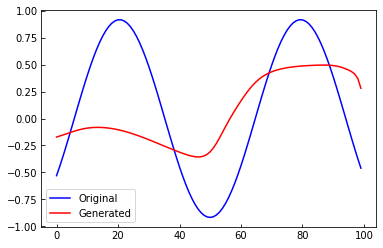

In [20]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), "b", label="Original")
plt.plot(nala_decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


### Visualize the learned results


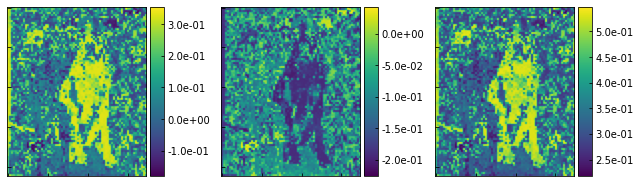

In [21]:
# Visualize the learned embeddings

embedding_maps(nala_encoded_, image)

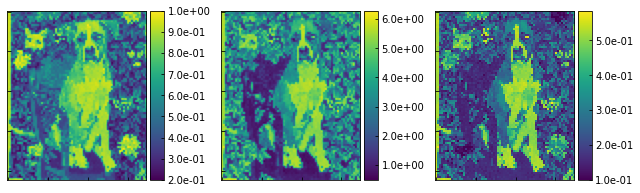

In [22]:
# visualize the actual RGB channels.

embedding_maps(_nala_params.reshape(-1, 3), image)


- **There is minimal resemblance to the true features**

- This is unsurprising because there are no rules that define what the embedding should look like.


## Let's try a bigger model

### Builds the model


In [23]:
device = "cuda"
latent_dim = 12

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [24]:
# views the model

model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

## Training


In [25]:
# trains the model

torch.manual_seed(0)
Train(
    model, encoder, decoder, dataloader, optimizer, 500,
)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.23it/s]

Epoch 0, Train Loss: 0.2132
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 1, Train Loss: 0.2114
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.91it/s]

Epoch 2, Train Loss: 0.2100
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 3, Train Loss: 0.2091
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.66it/s]

Epoch 4, Train Loss: 0.2087
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.16it/s]

Epoch 5, Train Loss: 0.2074
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.05it/s]

Epoch 6, Train Loss: 0.2073
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.35it/s]

Epoch 7, Train Loss: 0.2065
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.49it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 8, Train Loss: 0.2064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.32it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.41it/s]

Epoch 9, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.15it/s]

Epoch 10, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.29it/s]

Epoch 11, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.00it/s]

Epoch 12, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 13, Train Loss: 0.2058
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.48it/s]

Epoch 14, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.44it/s]

Epoch 15, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 16, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.37it/s]

Epoch 17, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 18, Train Loss: 0.2051
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.82it/s]

Epoch 19, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.72it/s]

Epoch 20, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.97it/s]

Epoch 21, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.53it/s]

Epoch 22, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.41it/s]

Epoch 23, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.35it/s]

Epoch 24, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.83it/s]

Epoch 25, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 26, Train Loss: 0.2058
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.71it/s]

Epoch 27, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.47it/s]

Epoch 28, Train Loss: 0.2050
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.48it/s]

Epoch 29, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.37it/s]

Epoch 30, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.61it/s]

Epoch 31, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 32, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.03it/s]

Epoch 33, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 34, Train Loss: 0.2058
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.02it/s]

Epoch 35, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 36, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.10it/s]

Epoch 37, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.83it/s]

Epoch 38, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.12it/s]

Epoch 39, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.50it/s]

Epoch 40, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 41, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.88it/s]

Epoch 42, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.44it/s]

Epoch 43, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.41it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.48it/s]

Epoch 44, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.44it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.59it/s]

Epoch 45, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.66it/s]

Epoch 46, Train Loss: 0.2057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.97it/s]

Epoch 47, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.95it/s]

Epoch 48, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.02it/s]

Epoch 49, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.73it/s]

Epoch 50, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.45it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.62it/s]

Epoch 51, Train Loss: 0.2057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.67it/s]

Epoch 52, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.30it/s]

Epoch 53, Train Loss: 0.2057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.54it/s]

Epoch 54, Train Loss: 0.2051
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.48it/s]

Epoch 55, Train Loss: 0.2049
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.90it/s]

Epoch 56, Train Loss: 0.2051
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.23it/s]

Epoch 57, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.54it/s]

Epoch 58, Train Loss: 0.2058
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.62it/s]

Epoch 59, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.99it/s]

Epoch 60, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.12it/s]

Epoch 61, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 98.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.37it/s]

Epoch 62, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.08it/s]

Epoch 63, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.34it/s]

Epoch 64, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.98it/s]

Epoch 65, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.50it/s]

Epoch 66, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.07it/s]

Epoch 67, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.65it/s]

Epoch 68, Train Loss: 0.2050
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 69, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.82it/s]

Epoch 70, Train Loss: 0.2049
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.04it/s]

Epoch 71, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.50it/s]

Epoch 72, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.21it/s]

Epoch 73, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 74, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.52it/s]

Epoch 75, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 76, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.63it/s]

Epoch 77, Train Loss: 0.2053
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.10it/s]

Epoch 78, Train Loss: 0.2052
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.35it/s]

Epoch 79, Train Loss: 0.2048
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.61it/s]

Epoch 80, Train Loss: 0.2049
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.84it/s]

Epoch 81, Train Loss: 0.2049
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.13it/s]

Epoch 82, Train Loss: 0.2050
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.07it/s]

Epoch 83, Train Loss: 0.2049
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.48it/s]

Epoch 84, Train Loss: 0.2049
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.59it/s]

Epoch 85, Train Loss: 0.2044
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.04it/s]

Epoch 86, Train Loss: 0.2044
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.63it/s]

Epoch 87, Train Loss: 0.2040
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.65it/s]

Epoch 88, Train Loss: 0.2034
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.54it/s]

Epoch 89, Train Loss: 0.2036
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.02it/s]

Epoch 90, Train Loss: 0.2030
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 98.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 91, Train Loss: 0.2022
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.55it/s]

Epoch 92, Train Loss: 0.2018
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.67it/s]

Epoch 93, Train Loss: 0.2006
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.00it/s]

Epoch 94, Train Loss: 0.1996
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.19it/s]

Epoch 95, Train Loss: 0.1983
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 96, Train Loss: 0.1969
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 97, Train Loss: 0.1967
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.43it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.81it/s]

Epoch 98, Train Loss: 0.1961
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.29it/s]

Epoch 99, Train Loss: 0.1961
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.46it/s]

Epoch 100, Train Loss: 0.1958
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.01it/s]

Epoch 101, Train Loss: 0.1958
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.50it/s]

Epoch 102, Train Loss: 0.1954
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.10it/s]

Epoch 103, Train Loss: 0.1954
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 104, Train Loss: 0.1958
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.61it/s]

Epoch 105, Train Loss: 0.1952
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 106, Train Loss: 0.1953
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.41it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.20it/s]

Epoch 107, Train Loss: 0.1951
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 108, Train Loss: 0.1951
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.49it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.73it/s]

Epoch 109, Train Loss: 0.1948
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.81it/s]

Epoch 110, Train Loss: 0.1950
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.15it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.80it/s]

Epoch 111, Train Loss: 0.1946
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.91it/s]

Epoch 112, Train Loss: 0.1946
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.31it/s]

Epoch 113, Train Loss: 0.1946
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.37it/s]

Epoch 114, Train Loss: 0.1942
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.32it/s]

Epoch 115, Train Loss: 0.1941
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.21it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.68it/s]

Epoch 116, Train Loss: 0.1937
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 117, Train Loss: 0.1935
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.32it/s]

Epoch 118, Train Loss: 0.1941
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.38it/s]

Epoch 119, Train Loss: 0.1936
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.43it/s]

Epoch 120, Train Loss: 0.1933
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.34it/s]

Epoch 121, Train Loss: 0.1932
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.27it/s]

Epoch 122, Train Loss: 0.1932
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.86it/s]

Epoch 123, Train Loss: 0.1927
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.25it/s]

Epoch 124, Train Loss: 0.1916
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 125, Train Loss: 0.1916
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 126, Train Loss: 0.1906
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.67it/s]

Epoch 127, Train Loss: 0.1903
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.73it/s]

Epoch 128, Train Loss: 0.1888
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.87it/s]

Epoch 129, Train Loss: 0.1885
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.19it/s]

Epoch 130, Train Loss: 0.1867
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.98it/s]

Epoch 131, Train Loss: 0.1860
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 132, Train Loss: 0.1846
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.11it/s]

Epoch 133, Train Loss: 0.1832
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.74it/s]

Epoch 134, Train Loss: 0.1824
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.63it/s]

Epoch 135, Train Loss: 0.1812
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.60it/s]

Epoch 136, Train Loss: 0.1808
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.66it/s]

Epoch 137, Train Loss: 0.1805
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.80it/s]

Epoch 138, Train Loss: 0.1798
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 139, Train Loss: 0.1796
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.73it/s]

Epoch 140, Train Loss: 0.1791
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.02it/s]

Epoch 141, Train Loss: 0.1788
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.54it/s]

Epoch 142, Train Loss: 0.1788
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 78.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.09it/s]

Epoch 143, Train Loss: 0.1785
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.60it/s]

Epoch 144, Train Loss: 0.1779
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.03it/s]

Epoch 145, Train Loss: 0.1784
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.60it/s]

Epoch 146, Train Loss: 0.1781
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.62it/s]

Epoch 147, Train Loss: 0.1777
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.04it/s]

Epoch 148, Train Loss: 0.1777
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 149, Train Loss: 0.1774
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.60it/s]

Epoch 150, Train Loss: 0.1768
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.05it/s]

Epoch 151, Train Loss: 0.1773
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.72it/s]

Epoch 152, Train Loss: 0.1771
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.14it/s]

Epoch 153, Train Loss: 0.1770
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.54it/s]

Epoch 154, Train Loss: 0.1771
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.18it/s]

Epoch 155, Train Loss: 0.1761
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.19it/s]

Epoch 156, Train Loss: 0.1769
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.04it/s]

Epoch 157, Train Loss: 0.1767
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|████████████████████████████████████████▌                                        | 10/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.58it/s]

Epoch 158, Train Loss: 0.1762
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.54it/s]

Epoch 159, Train Loss: 0.1767
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.53it/s]

Epoch 160, Train Loss: 0.1760
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.90it/s]

Epoch 161, Train Loss: 0.1756
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.30it/s]

Epoch 162, Train Loss: 0.1758
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.45it/s]

Epoch 163, Train Loss: 0.1759
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.50it/s]

Epoch 164, Train Loss: 0.1755
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.60it/s]

Epoch 165, Train Loss: 0.1757
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.20it/s]

Epoch 166, Train Loss: 0.1754
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.07it/s]

Epoch 167, Train Loss: 0.1756
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.91it/s]

Epoch 168, Train Loss: 0.1751
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 99.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.05it/s]

Epoch 169, Train Loss: 0.1753
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 99.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.54it/s]

Epoch 170, Train Loss: 0.1747
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.17it/s]

Epoch 171, Train Loss: 0.1748
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.62it/s]

Epoch 172, Train Loss: 0.1747
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.02it/s]

Epoch 173, Train Loss: 0.1744
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.26it/s]

Epoch 174, Train Loss: 0.1742
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.76it/s]

Epoch 175, Train Loss: 0.1744
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 60.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 64.16it/s]

Epoch 176, Train Loss: 0.1746
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 70.97it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 78.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 78.21it/s]

Epoch 177, Train Loss: 0.1740
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.38it/s]

Epoch 178, Train Loss: 0.1741
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.41it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.17it/s]

Epoch 179, Train Loss: 0.1742
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.69it/s]

Epoch 180, Train Loss: 0.1742
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.91it/s]

Epoch 181, Train Loss: 0.1739
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.13it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.06it/s]

Epoch 182, Train Loss: 0.1736
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.04it/s]

Epoch 183, Train Loss: 0.1736
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.45it/s]

Epoch 184, Train Loss: 0.1737
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.50it/s]

Epoch 185, Train Loss: 0.1731
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 186, Train Loss: 0.1734
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.67it/s]

Epoch 187, Train Loss: 0.1734
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.99it/s]

Epoch 188, Train Loss: 0.1732
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.88it/s]

Epoch 189, Train Loss: 0.1725
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.04it/s]

Epoch 190, Train Loss: 0.1725
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.00it/s]

Epoch 191, Train Loss: 0.1723
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 192, Train Loss: 0.1714
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 193, Train Loss: 0.1705
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.33it/s]

Epoch 194, Train Loss: 0.1701
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.40it/s]

Epoch 195, Train Loss: 0.1690
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.01it/s]

Epoch 196, Train Loss: 0.1680
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 80.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.75it/s]

Epoch 197, Train Loss: 0.1670
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.54it/s]

Epoch 198, Train Loss: 0.1657
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.52it/s]

Epoch 199, Train Loss: 0.1653
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.34it/s]

Epoch 200, Train Loss: 0.1633
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.40it/s]

Epoch 201, Train Loss: 0.1626
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.20it/s]

Epoch 202, Train Loss: 0.1617
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.20it/s]

Epoch 203, Train Loss: 0.1613
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 204, Train Loss: 0.1598
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.39it/s]

Epoch 205, Train Loss: 0.1590
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.38it/s]

Epoch 206, Train Loss: 0.1583
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.47it/s]

Epoch 207, Train Loss: 0.1575
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.07it/s]

Epoch 208, Train Loss: 0.1569
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.05it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.98it/s]

Epoch 209, Train Loss: 0.1560
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.64it/s]

Epoch 210, Train Loss: 0.1557
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.59it/s]

Epoch 211, Train Loss: 0.1550
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 92.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.47it/s]

Epoch 212, Train Loss: 0.1552
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.55it/s]

Epoch 213, Train Loss: 0.1542
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 214, Train Loss: 0.1552
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.23it/s]

Epoch 215, Train Loss: 0.1535
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 216, Train Loss: 0.1533
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.22it/s]

Epoch 217, Train Loss: 0.1542
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.57it/s]

Epoch 218, Train Loss: 0.1539
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 219, Train Loss: 0.1531
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 220, Train Loss: 0.1526
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.83it/s]

Epoch 221, Train Loss: 0.1529
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.53it/s]

Epoch 222, Train Loss: 0.1526
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.41it/s]

Epoch 223, Train Loss: 0.1522
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 224, Train Loss: 0.1517
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.58it/s]

Epoch 225, Train Loss: 0.1525
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 226, Train Loss: 0.1519
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.55it/s]

Epoch 227, Train Loss: 0.1513
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 228, Train Loss: 0.1517
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 229, Train Loss: 0.1524
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.88it/s]

Epoch 230, Train Loss: 0.1512
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.11it/s]

Epoch 231, Train Loss: 0.1509
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.44it/s]

Epoch 232, Train Loss: 0.1512
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 92.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.72it/s]

Epoch 233, Train Loss: 0.1510
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 234, Train Loss: 0.1508
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.97it/s]

Epoch 235, Train Loss: 0.1507
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.02it/s]

Epoch 236, Train Loss: 0.1503
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 237, Train Loss: 0.1498
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.73it/s]

Epoch 238, Train Loss: 0.1506
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.27it/s]

Epoch 239, Train Loss: 0.1504
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.74it/s]

Epoch 240, Train Loss: 0.1501
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.30it/s]

Epoch 241, Train Loss: 0.1502
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 242, Train Loss: 0.1496
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.69it/s]

Epoch 243, Train Loss: 0.1498
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.58it/s]

Epoch 244, Train Loss: 0.1492
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.14it/s]

Epoch 245, Train Loss: 0.1494
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 246, Train Loss: 0.1494
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.07it/s]

Epoch 247, Train Loss: 0.1491
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.05it/s]

Epoch 248, Train Loss: 0.1492
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.31it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.29it/s]

Epoch 249, Train Loss: 0.1495
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.28it/s]

Epoch 250, Train Loss: 0.1487
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 251, Train Loss: 0.1488
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 252, Train Loss: 0.1484
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.13it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.93it/s]

Epoch 253, Train Loss: 0.1485
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.31it/s]

Epoch 254, Train Loss: 0.1487
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.02it/s]

Epoch 255, Train Loss: 0.1481
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.73it/s]

Epoch 256, Train Loss: 0.1480
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.38it/s]

Epoch 257, Train Loss: 0.1483
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.74it/s]

Epoch 258, Train Loss: 0.1484
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.52it/s]

Epoch 259, Train Loss: 0.1480
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 260, Train Loss: 0.1484
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.03it/s]

Epoch 261, Train Loss: 0.1477
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.14it/s]

Epoch 262, Train Loss: 0.1476
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.30it/s]

Epoch 263, Train Loss: 0.1474
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 80.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.24it/s]

Epoch 264, Train Loss: 0.1477
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.05it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.54it/s]

Epoch 265, Train Loss: 0.1475
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 266, Train Loss: 0.1478
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.50it/s]

Epoch 267, Train Loss: 0.1472
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.70it/s]

Epoch 268, Train Loss: 0.1475
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.19it/s]

Epoch 269, Train Loss: 0.1471
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.65it/s]

Epoch 270, Train Loss: 0.1471
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.68it/s]

Epoch 271, Train Loss: 0.1466
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.16it/s]

Epoch 272, Train Loss: 0.1469
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.02it/s]

Epoch 273, Train Loss: 0.1465
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.26it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.70it/s]

Epoch 274, Train Loss: 0.1465
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 79.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 89.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.79it/s]

Epoch 275, Train Loss: 0.1467
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.99it/s]

Epoch 276, Train Loss: 0.1466
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.54it/s]

Epoch 277, Train Loss: 0.1461
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.52it/s]

Epoch 278, Train Loss: 0.1462
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.85it/s]

Epoch 279, Train Loss: 0.1464
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.98it/s]

Epoch 280, Train Loss: 0.1462
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.96it/s]

Epoch 281, Train Loss: 0.1461
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.06it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.77it/s]

Epoch 282, Train Loss: 0.1461
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.04it/s]

Epoch 283, Train Loss: 0.1458
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.57it/s]

Epoch 284, Train Loss: 0.1456
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.83it/s]

Epoch 285, Train Loss: 0.1456
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.02it/s]

Epoch 286, Train Loss: 0.1459
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.49it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.44it/s]

Epoch 287, Train Loss: 0.1456
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.45it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.48it/s]

Epoch 288, Train Loss: 0.1457
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.50it/s]

Epoch 289, Train Loss: 0.1459
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.41it/s]

Epoch 290, Train Loss: 0.1453
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.22it/s]

Epoch 291, Train Loss: 0.1453
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.62it/s]

Epoch 292, Train Loss: 0.1453
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.68it/s]

Epoch 293, Train Loss: 0.1450
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.03it/s]

Epoch 294, Train Loss: 0.1448
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.59it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.13it/s]

Epoch 295, Train Loss: 0.1448
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.41it/s]

Epoch 296, Train Loss: 0.1447
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.65it/s]

Epoch 297, Train Loss: 0.1448
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.97it/s]

Epoch 298, Train Loss: 0.1447
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.85it/s]

Epoch 299, Train Loss: 0.1449
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.74it/s]

Epoch 300, Train Loss: 0.1445
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.00it/s]

Epoch 301, Train Loss: 0.1446
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.69it/s]

Epoch 302, Train Loss: 0.1443
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.69it/s]

Epoch 303, Train Loss: 0.1443
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.44it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.83it/s]

Epoch 304, Train Loss: 0.1447
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.02it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.17it/s]

Epoch 305, Train Loss: 0.1442
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.02it/s]

Epoch 306, Train Loss: 0.1439
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.07it/s]

Epoch 307, Train Loss: 0.1442
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.38it/s]

Epoch 308, Train Loss: 0.1442
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.42it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.47it/s]

Epoch 309, Train Loss: 0.1438
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.45it/s]

Epoch 310, Train Loss: 0.1445
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.69it/s]

Epoch 311, Train Loss: 0.1440
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.48it/s]

Epoch 312, Train Loss: 0.1439
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 313, Train Loss: 0.1438
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.98it/s]

Epoch 314, Train Loss: 0.1439
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.32it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 315, Train Loss: 0.1443
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.65it/s]

Epoch 316, Train Loss: 0.1439
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 88.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.11it/s]

Epoch 317, Train Loss: 0.1435
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.07it/s]

Epoch 318, Train Loss: 0.1439
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 99.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.08it/s]

Epoch 319, Train Loss: 0.1444
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.19it/s]

Epoch 320, Train Loss: 0.1437
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 321, Train Loss: 0.1436
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.36it/s]

Epoch 322, Train Loss: 0.1429
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.67it/s]

Epoch 323, Train Loss: 0.1431
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.70it/s]

Epoch 324, Train Loss: 0.1436
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.65it/s]

Epoch 325, Train Loss: 0.1433
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 326, Train Loss: 0.1432
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.08it/s]

Epoch 327, Train Loss: 0.1430
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.64it/s]

Epoch 328, Train Loss: 0.1430
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.91it/s]

Epoch 329, Train Loss: 0.1430
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 330, Train Loss: 0.1430
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.10it/s]

Epoch 331, Train Loss: 0.1424
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 332, Train Loss: 0.1427
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 333, Train Loss: 0.1427
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.59it/s]

Epoch 334, Train Loss: 0.1426
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.54it/s]

Epoch 335, Train Loss: 0.1428
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.10it/s]

Epoch 336, Train Loss: 0.1425
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.07it/s]

Epoch 337, Train Loss: 0.1427
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.49it/s]

Epoch 338, Train Loss: 0.1422
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 339, Train Loss: 0.1423
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.06it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 340, Train Loss: 0.1422
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.12it/s]

Epoch 341, Train Loss: 0.1425
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.31it/s]

Epoch 342, Train Loss: 0.1420
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 343, Train Loss: 0.1421
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 344, Train Loss: 0.1418
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.71it/s]

Epoch 345, Train Loss: 0.1420
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 346, Train Loss: 0.1419
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.72it/s]

Epoch 347, Train Loss: 0.1420
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 348, Train Loss: 0.1419
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.23it/s]

Epoch 349, Train Loss: 0.1420
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 79.53it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 83.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.53it/s]

Epoch 350, Train Loss: 0.1418
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.64it/s]

Epoch 351, Train Loss: 0.1417
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 352, Train Loss: 0.1415
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.85it/s]

Epoch 353, Train Loss: 0.1415
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.48it/s]

Epoch 354, Train Loss: 0.1416
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.38it/s]

Epoch 355, Train Loss: 0.1416
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 356, Train Loss: 0.1418
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 357, Train Loss: 0.1413
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.45it/s]

Epoch 358, Train Loss: 0.1412
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.37it/s]

Epoch 359, Train Loss: 0.1411
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.12it/s]

Epoch 360, Train Loss: 0.1408
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 361, Train Loss: 0.1412
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.74it/s]

Epoch 362, Train Loss: 0.1414
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.46it/s]

Epoch 363, Train Loss: 0.1411
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 80.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.08it/s]

Epoch 364, Train Loss: 0.1409
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.91it/s]

Epoch 365, Train Loss: 0.1407
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.63it/s]

Epoch 366, Train Loss: 0.1408
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 367, Train Loss: 0.1409
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.20it/s]

Epoch 368, Train Loss: 0.1405
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 369, Train Loss: 0.1405
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

Epoch 370, Train Loss: 0.1406
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.47it/s]

Epoch 371, Train Loss: 0.1408
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.50it/s]

Epoch 372, Train Loss: 0.1405
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.95it/s]

Epoch 373, Train Loss: 0.1403
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.00it/s]

Epoch 374, Train Loss: 0.1403
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.55it/s]

Epoch 375, Train Loss: 0.1409
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 376, Train Loss: 0.1402
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.18it/s]

Epoch 377, Train Loss: 0.1405
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.04it/s]

Epoch 378, Train Loss: 0.1402
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.64it/s]

Epoch 379, Train Loss: 0.1400
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

Epoch 380, Train Loss: 0.1406
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.58it/s]

Epoch 381, Train Loss: 0.1399
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 382, Train Loss: 0.1401
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.35it/s]

Epoch 383, Train Loss: 0.1401
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 35%|█████████████████████████████                                                      | 7/20 [00:00<00:00, 55.11it/s]

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:00<00:00, 53.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 61.35it/s]

Epoch 384, Train Loss: 0.1398
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 385, Train Loss: 0.1396
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.13it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.49it/s]

Epoch 386, Train Loss: 0.1401
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.49it/s]

Epoch 387, Train Loss: 0.1399
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.15it/s]

Epoch 388, Train Loss: 0.1395
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 79.19it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 81.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.98it/s]

Epoch 389, Train Loss: 0.1394
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 390, Train Loss: 0.1401
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 391, Train Loss: 0.1393
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.78it/s]

Epoch 392, Train Loss: 0.1394
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.14it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.63it/s]

Epoch 393, Train Loss: 0.1394
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.88it/s]

Epoch 394, Train Loss: 0.1395
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.38it/s]

Epoch 395, Train Loss: 0.1390
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.25it/s]

Epoch 396, Train Loss: 0.1387
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.67it/s]

Epoch 397, Train Loss: 0.1388
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.31it/s]

Epoch 398, Train Loss: 0.1389
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 399, Train Loss: 0.1385
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.48it/s]

Epoch 400, Train Loss: 0.1388
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.39it/s]

Epoch 401, Train Loss: 0.1388
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.77it/s]

Epoch 402, Train Loss: 0.1384
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.67it/s]

Epoch 403, Train Loss: 0.1383
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.13it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.04it/s]

Epoch 404, Train Loss: 0.1386
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.03it/s]

Epoch 405, Train Loss: 0.1381
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 406, Train Loss: 0.1382
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.31it/s]

Epoch 407, Train Loss: 0.1378
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 408, Train Loss: 0.1376
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.01it/s]

Epoch 409, Train Loss: 0.1376
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.82it/s]

Epoch 410, Train Loss: 0.1375
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.48it/s]

Epoch 411, Train Loss: 0.1374
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.09it/s]

Epoch 412, Train Loss: 0.1371
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.13it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.64it/s]

Epoch 413, Train Loss: 0.1369
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.83it/s]

Epoch 414, Train Loss: 0.1368
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.35it/s]

Epoch 415, Train Loss: 0.1364
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.38it/s]

Epoch 416, Train Loss: 0.1365
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.03it/s]

Epoch 417, Train Loss: 0.1362
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.15it/s]

Epoch 418, Train Loss: 0.1364
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.46it/s]

Epoch 419, Train Loss: 0.1361
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.32it/s]

Epoch 420, Train Loss: 0.1357
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.77it/s]

Epoch 421, Train Loss: 0.1355
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 422, Train Loss: 0.1351
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 423, Train Loss: 0.1348
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 424, Train Loss: 0.1343
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 425, Train Loss: 0.1338
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.69it/s]

Epoch 426, Train Loss: 0.1338
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.98it/s]

Epoch 427, Train Loss: 0.1330
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.56it/s]

Epoch 428, Train Loss: 0.1330
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.69it/s]

Epoch 429, Train Loss: 0.1325
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.32it/s]

Epoch 430, Train Loss: 0.1322
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.81it/s]

Epoch 431, Train Loss: 0.1318
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.09it/s]

Epoch 432, Train Loss: 0.1314
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.32it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 90.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.62it/s]

Epoch 433, Train Loss: 0.1308
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.56it/s]

Epoch 434, Train Loss: 0.1309
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.61it/s]

Epoch 435, Train Loss: 0.1304
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.60it/s]

Epoch 436, Train Loss: 0.1303
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 437, Train Loss: 0.1300
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.67it/s]

Epoch 438, Train Loss: 0.1296
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

Epoch 439, Train Loss: 0.1294
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.04it/s]

Epoch 440, Train Loss: 0.1288
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.09it/s]

Epoch 441, Train Loss: 0.1290
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.73it/s]

Epoch 442, Train Loss: 0.1284
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 443, Train Loss: 0.1284
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 444, Train Loss: 0.1286
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.75it/s]

Epoch 445, Train Loss: 0.1281
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.36it/s]

Epoch 446, Train Loss: 0.1280
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 76.92it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 82.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 447, Train Loss: 0.1275
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.99it/s]

Epoch 448, Train Loss: 0.1275
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.44it/s]

Epoch 449, Train Loss: 0.1271
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.02it/s]

Epoch 450, Train Loss: 0.1267
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.27it/s]

Epoch 451, Train Loss: 0.1270
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.37it/s]

Epoch 452, Train Loss: 0.1264
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 453, Train Loss: 0.1262
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.79it/s]

Epoch 454, Train Loss: 0.1262
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.66it/s]

Epoch 455, Train Loss: 0.1261
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.04it/s]

Epoch 456, Train Loss: 0.1264
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.68it/s]

Epoch 457, Train Loss: 0.1260
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.04it/s]

Epoch 458, Train Loss: 0.1257
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.33it/s]

Epoch 459, Train Loss: 0.1253
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.87it/s]

Epoch 460, Train Loss: 0.1257
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.01it/s]

Epoch 461, Train Loss: 0.1251
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.32it/s]

Epoch 462, Train Loss: 0.1252
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.01it/s]

Epoch 463, Train Loss: 0.1247
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.77it/s]

Epoch 464, Train Loss: 0.1246
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.29it/s]

Epoch 465, Train Loss: 0.1253
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.11it/s]

Epoch 466, Train Loss: 0.1247
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.36it/s]

Epoch 467, Train Loss: 0.1248
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.11it/s]

Epoch 468, Train Loss: 0.1246
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.22it/s]

Epoch 469, Train Loss: 0.1240
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.45it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.80it/s]

Epoch 470, Train Loss: 0.1242
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.27it/s]

Epoch 471, Train Loss: 0.1240
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.79it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.28it/s]

Epoch 472, Train Loss: 0.1239
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.02it/s]

Epoch 473, Train Loss: 0.1237
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.23it/s]

Epoch 474, Train Loss: 0.1235
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 475, Train Loss: 0.1234
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.83it/s]

Epoch 476, Train Loss: 0.1233
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.01it/s]

Epoch 477, Train Loss: 0.1234
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 478, Train Loss: 0.1233
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.09it/s]

Epoch 479, Train Loss: 0.1231
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.77it/s]

Epoch 480, Train Loss: 0.1229
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.06it/s]

Epoch 481, Train Loss: 0.1227
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 482, Train Loss: 0.1227
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.72it/s]

Epoch 483, Train Loss: 0.1225
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 484, Train Loss: 0.1231
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.14it/s]

Epoch 485, Train Loss: 0.1226
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.00it/s]

Epoch 486, Train Loss: 0.1221
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 487, Train Loss: 0.1220
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 488, Train Loss: 0.1223
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 78.93it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 88.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.32it/s]

Epoch 489, Train Loss: 0.1223
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.07it/s]

Epoch 490, Train Loss: 0.1221
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.02it/s]

Epoch 491, Train Loss: 0.1219
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.93it/s]

Epoch 492, Train Loss: 0.1216
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.58it/s]

Epoch 493, Train Loss: 0.1220
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.60it/s]

Epoch 494, Train Loss: 0.1212
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.63it/s]

Epoch 495, Train Loss: 0.1213
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.18it/s]

Epoch 496, Train Loss: 0.1212
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.60it/s]

Epoch 497, Train Loss: 0.1217
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.59it/s]

Epoch 498, Train Loss: 0.1214
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 499, Train Loss: 0.1209
.............................


### Visualize the reconstruction


In [26]:
# computes an example reconstruction for a minibatch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)


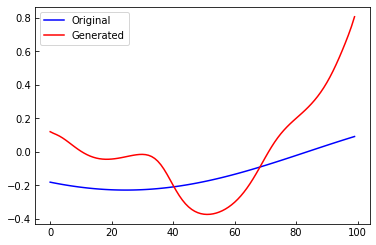

In [27]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


- Reconstruction is slightly better but just more overfit


### Visualize the learned results


In [28]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder, decoder)


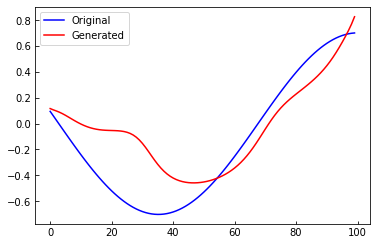

In [29]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), "b", label="Original")
plt.plot(nala_decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


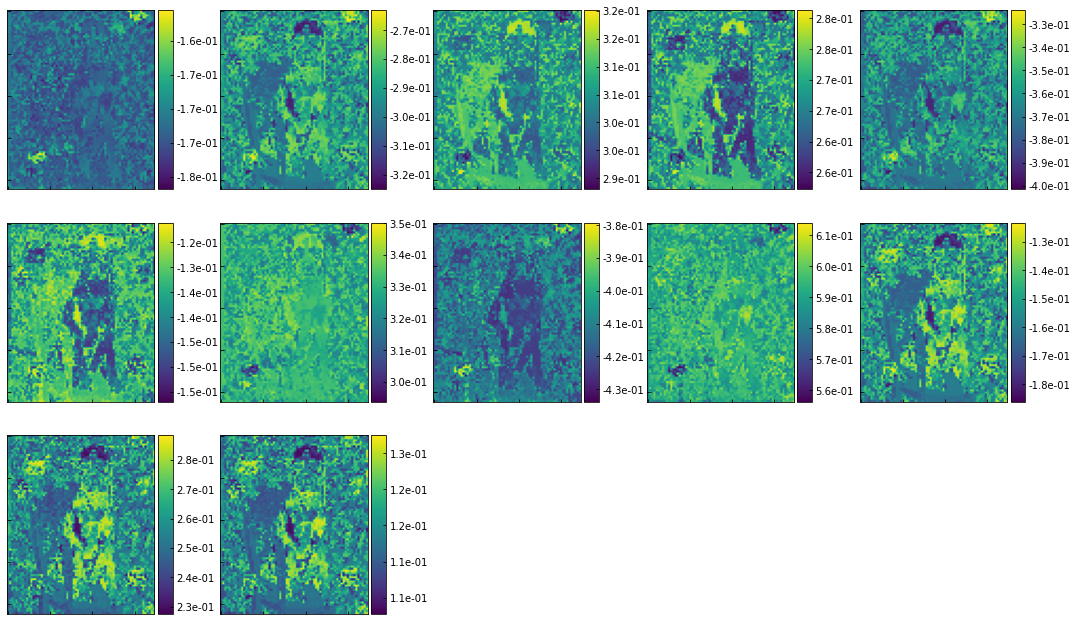

In [30]:
# Visualize the learned embeddings

embedding_maps(nala_encoded_, image)

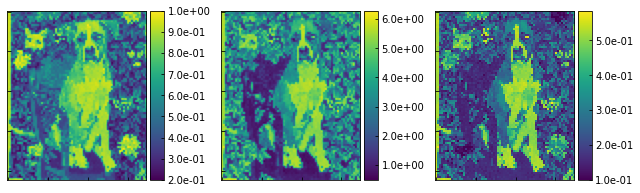

In [31]:
# visualize the actual RGB channels.

embedding_maps(_nala_params.reshape(-1, 3), image)


- **Now there are just more features but no resemblance between the parameters.**
- It would be impossible to have any resemblance to the features since it is overcomplete.


## Physics constrained neural network

### Building the model


In [32]:
class DensePhysLarger(nn.Module):
    def __init__(
        self,
        x_vector,
        model,
        dense_params=3,
        verbose=False,
        device="cuda",
        num_channels=1,
        **kwargs
    ):
        """

        Args:
            x_vector: The vector of values for x
            model: the empirical function to fit
            dense_params: number of output parameters to the model
            verbose: sets if the model is verbose
            device: device where the model will run
            num_channels: number of channels in the input
        """

        super().__init__()
        self.dense_params = dense_params
        self.x_vector = x_vector
        self.verbose = verbose
        self.num_channels = num_channels
        self.device = device
        self.model_params = kwargs.get("model_params")
        self.model = model  # (self.x_vector, size=(num_channels, dense_params // self.model_params))
        self.sigmoid = nn.Sigmoid()
        n = 4

        if torch.cuda.is_available():
            self.cuda()

        # Input block of 1d convolution

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.num_channels, out_channels=8 * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8 * n, out_channels=6 * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6 * n, out_channels=4, kernel_size=5),
            nn.SELU(),
        )

        self.hidden_x1_shape = self.hidden_x1(
            torch.zeros(1, self.num_channels, self.x_vector.shape[0])
        ).shape

        # fully connected block

        self.hidden_xfc = nn.Sequential(
            nn.Linear(self.hidden_x1_shape[1] * self.hidden_x1_shape[2], 20),
            nn.SELU(),
            nn.Linear(20, 20),
            nn.SELU(),
        )

        # out of size 20

        self.hidden_xfc_shape = self.hidden_xfc(
            torch.zeros(1, self.hidden_x1_shape[1] * self.hidden_x1_shape[2])
        ).shape

        # 2nd block of 1d-conv layers

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=1, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4 * n, out_channels=2 * n, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2 * n, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
        )

        self.hidden_x2_shape = self.hidden_x2(
            torch.zeros(
                (
                    self.hidden_xfc_shape[0],
                    1,
                    self.hidden_x1_shape[1] * self.hidden_x1_shape[2],
                )
            )
        ).shape

        # Flatten layer

        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output 4 values - linear

        self.hidden_embedding = nn.Sequential(
            nn.Linear(
                self.hidden_x2_shape[1] * self.hidden_x2_shape[2]
                + self.hidden_xfc_shape[1],
                16,
            ),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.dense_params),
        )

    def forward(self, x, n=-1):

        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (x.shape[0], -1))  # batch size, features
        xfc = self.hidden_xfc(xfc)
        x = torch.reshape(
            x, (x.shape[0], 1, self.hidden_x1_shape[1] * self.hidden_x1_shape[2])
        )
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv.

        embedding = self.hidden_embedding(encoded)  # output is 3 parameters

        embedding = torch.reshape(embedding, (embedding.shape[0], 3, -1))

        embedding[:, 0, :] = (
            embedding[:, 0, :] * self.model.amp_sd + self.model.amp_mean
        )
        embedding[:, 1, :] = (
            embedding[:, 1, :] * self.model.phase_sd + self.model.phase_mean
        )
        embedding[:, 2, :] = (
            embedding[:, 2, :] * self.model.frequency_sd + self.model.frequency_mean
        )

        embedding = torch.reshape(embedding, (embedding.shape[0], -1))

        embedding = torch.abs(embedding)
        self.embed = embedding

        (out, _) = self.model.compute(embedding, device=self.device)

        out = torch.transpose(out, 1, 2)
        out = torch.atleast_3d(out)

        return (out.to(self.device), embedding.to(self.device))

In [33]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(
    x_vector, constructor, dense_params=3, model_params=3, verbose=False
)

if torch.cuda.is_available():
    model.cuda()

### Dataloader


In [34]:
# builds the dataloader

dataloader = DataLoader(
    torch.transpose(spectra_full, 1, 2), batch_size=512, shuffle=True, num_workers=0
)

### Training


In [35]:
set_seeds(42)

loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


epochs = 200

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in dataloader:
        pred, _ = model(train_batch.cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))

C:\Conda\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\engine.cpp:1000.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch : 0/200, recon loss = 0.34065007
--- 0.22906184196472168 seconds ---
epoch : 1/200, recon loss = 0.32572794
--- 0.1919693946838379 seconds ---


epoch : 2/200, recon loss = 0.30779447
--- 0.18799901008605957 seconds ---
epoch : 3/200, recon loss = 0.28739912
--- 0.18712639808654785 seconds ---


epoch : 4/200, recon loss = 0.26676472
--- 0.19020390510559082 seconds ---
epoch : 5/200, recon loss = 0.24804862
--- 0.18598723411560059 seconds ---


epoch : 6/200, recon loss = 0.23242436
--- 0.1880030632019043 seconds ---
epoch : 7/200, recon loss = 0.21998294
--- 0.18899226188659668 seconds ---


epoch : 8/200, recon loss = 0.21048479
--- 0.1900033950805664 seconds ---
epoch : 9/200, recon loss = 0.20338247
--- 0.19218087196350098 seconds ---


epoch : 10/200, recon loss = 0.19790034
--- 0.19097185134887695 seconds ---
epoch : 11/200, recon loss = 0.19324190
--- 0.19503331184387207 seconds ---


epoch : 12/200, recon loss = 0.18881758
--- 0.1915886402130127 seconds ---
epoch : 13/200, recon loss = 0.18437931
--- 0.18900132179260254 seconds ---


epoch : 14/200, recon loss = 0.18005600
--- 0.18799996376037598 seconds ---
epoch : 15/200, recon loss = 0.17569274
--- 0.19046235084533691 seconds ---


epoch : 16/200, recon loss = 0.17130655
--- 0.19800305366516113 seconds ---
epoch : 17/200, recon loss = 0.16681274
--- 0.20099663734436035 seconds ---


epoch : 18/200, recon loss = 0.16230803
--- 0.19798922538757324 seconds ---


epoch : 19/200, recon loss = 0.15781171
--- 0.20163202285766602 seconds ---


epoch : 20/200, recon loss = 0.15334375
--- 0.20114541053771973 seconds ---


epoch : 21/200, recon loss = 0.14903816
--- 0.20299744606018066 seconds ---
epoch : 22/200, recon loss = 0.14489461
--- 0.1968235969543457 seconds ---


epoch : 23/200, recon loss = 0.14106148
--- 0.19800639152526855 seconds ---


epoch : 24/200, recon loss = 0.13743761
--- 0.20000195503234863 seconds ---
epoch : 25/200, recon loss = 0.13414013
--- 0.1982715129852295 seconds ---
epoch : 26/200, recon loss = 0.13098969
--- 0.1969590187072754 seconds ---


epoch : 27/200, recon loss = 0.12805031
--- 0.1999959945678711 seconds ---


epoch : 28/200, recon loss = 0.12525687
--- 0.20206403732299805 seconds ---
epoch : 29/200, recon loss = 0.12260640
--- 0.19899487495422363 seconds ---


epoch : 30/200, recon loss = 0.12003942
--- 0.1990664005279541 seconds ---
epoch : 31/200, recon loss = 0.11760770
--- 0.19921875 seconds ---


epoch : 32/200, recon loss = 0.11520550
--- 0.20000648498535156 seconds ---


epoch : 33/200, recon loss = 0.11290327
--- 0.21599411964416504 seconds ---
epoch : 34/200, recon loss = 0.11065438
--- 0.19899916648864746 seconds ---


epoch : 35/200, recon loss = 0.10844134
--- 0.20301508903503418 seconds ---


epoch : 36/200, recon loss = 0.10627043
--- 0.20030856132507324 seconds ---


epoch : 37/200, recon loss = 0.10416325
--- 0.2040412425994873 seconds ---
epoch : 38/200, recon loss = 0.10211157
--- 0.20099759101867676 seconds ---


epoch : 39/200, recon loss = 0.10013044
--- 0.20371150970458984 seconds ---
epoch : 40/200, recon loss = 0.09818144
--- 0.19899606704711914 seconds ---


epoch : 41/200, recon loss = 0.09630308
--- 0.199432373046875 seconds ---


epoch : 42/200, recon loss = 0.09447757
--- 0.20200419425964355 seconds ---


epoch : 43/200, recon loss = 0.09272053
--- 0.20201373100280762 seconds ---


epoch : 44/200, recon loss = 0.09100577
--- 0.20226669311523438 seconds ---


epoch : 45/200, recon loss = 0.08932835
--- 0.20920634269714355 seconds ---


epoch : 46/200, recon loss = 0.08768320
--- 0.20033788681030273 seconds ---
epoch : 47/200, recon loss = 0.08606616
--- 0.20205283164978027 seconds ---


epoch : 48/200, recon loss = 0.08447172
--- 0.20317745208740234 seconds ---


epoch : 49/200, recon loss = 0.08290530
--- 0.20499730110168457 seconds ---
epoch : 50/200, recon loss = 0.08137275
--- 0.19815897941589355 seconds ---


epoch : 51/200, recon loss = 0.07984612
--- 0.20600128173828125 seconds ---


epoch : 52/200, recon loss = 0.07834564
--- 0.202012300491333 seconds ---


epoch : 53/200, recon loss = 0.07688210
--- 0.2050015926361084 seconds ---


epoch : 54/200, recon loss = 0.07544541
--- 0.20200777053833008 seconds ---


epoch : 55/200, recon loss = 0.07401390
--- 0.20499086380004883 seconds ---
epoch : 56/200, recon loss = 0.07262550
--- 0.20099782943725586 seconds ---


epoch : 57/200, recon loss = 0.07124257
--- 0.2009735107421875 seconds ---


epoch : 58/200, recon loss = 0.06988686
--- 0.2019960880279541 seconds ---


epoch : 59/200, recon loss = 0.06854724
--- 0.2030184268951416 seconds ---


epoch : 60/200, recon loss = 0.06722313
--- 0.20133447647094727 seconds ---


epoch : 61/200, recon loss = 0.06589259
--- 0.20339369773864746 seconds ---


epoch : 62/200, recon loss = 0.06457108
--- 0.20118236541748047 seconds ---


epoch : 63/200, recon loss = 0.06328106
--- 0.2039957046508789 seconds ---
epoch : 64/200, recon loss = 0.06197824
--- 0.1994328498840332 seconds ---


epoch : 65/200, recon loss = 0.06068059
--- 0.20302748680114746 seconds ---


epoch : 66/200, recon loss = 0.05938280
--- 0.20263361930847168 seconds ---


epoch : 67/200, recon loss = 0.05809648
--- 0.20301461219787598 seconds ---


epoch : 68/200, recon loss = 0.05680543
--- 0.20604801177978516 seconds ---
epoch : 69/200, recon loss = 0.05551522
--- 0.1970357894897461 seconds ---


epoch : 70/200, recon loss = 0.05422040
--- 0.20400714874267578 seconds ---


epoch : 71/200, recon loss = 0.05295468
--- 0.20299863815307617 seconds ---


epoch : 72/200, recon loss = 0.05170373
--- 0.20234417915344238 seconds ---


epoch : 73/200, recon loss = 0.05047628
--- 0.20994257926940918 seconds ---
epoch : 74/200, recon loss = 0.04926908
--- 0.1999986171722412 seconds ---


epoch : 75/200, recon loss = 0.04808381
--- 0.19808626174926758 seconds ---


epoch : 76/200, recon loss = 0.04694727
--- 0.20193147659301758 seconds ---


epoch : 77/200, recon loss = 0.04581532
--- 0.20122337341308594 seconds ---
epoch : 78/200, recon loss = 0.04470813
--- 0.1989576816558838 seconds ---


epoch : 79/200, recon loss = 0.04364410
--- 0.20066118240356445 seconds ---
epoch : 80/200, recon loss = 0.04258774
--- 0.19997549057006836 seconds ---


epoch : 81/200, recon loss = 0.04156115
--- 0.20100975036621094 seconds ---


epoch : 82/200, recon loss = 0.04057291
--- 0.2090601921081543 seconds ---
epoch : 83/200, recon loss = 0.03961464
--- 0.20014381408691406 seconds ---


epoch : 84/200, recon loss = 0.03873673
--- 0.2010042667388916 seconds ---
epoch : 85/200, recon loss = 0.03785234
--- 0.19644808769226074 seconds ---


epoch : 86/200, recon loss = 0.03701373
--- 0.19798040390014648 seconds ---


epoch : 87/200, recon loss = 0.03622336
--- 0.20194649696350098 seconds ---
epoch : 88/200, recon loss = 0.03546652
--- 0.20006299018859863 seconds ---


epoch : 89/200, recon loss = 0.03473796
--- 0.1939375400543213 seconds ---
epoch : 90/200, recon loss = 0.03402665
--- 0.19405007362365723 seconds ---


epoch : 91/200, recon loss = 0.03336283
--- 0.20237135887145996 seconds ---


epoch : 92/200, recon loss = 0.03273432
--- 0.20200133323669434 seconds ---
epoch : 93/200, recon loss = 0.03211708
--- 0.19893383979797363 seconds ---


epoch : 94/200, recon loss = 0.03151769
--- 0.2030477523803711 seconds ---
epoch : 95/200, recon loss = 0.03098166
--- 0.19799232482910156 seconds ---


epoch : 96/200, recon loss = 0.03044664
--- 0.20171451568603516 seconds ---


epoch : 97/200, recon loss = 0.02989103
--- 0.20100688934326172 seconds ---
epoch : 98/200, recon loss = 0.02940526
--- 0.1990063190460205 seconds ---


epoch : 99/200, recon loss = 0.02889985
--- 0.20598268508911133 seconds ---
epoch : 100/200, recon loss = 0.02841020
--- 0.1979532241821289 seconds ---


epoch : 101/200, recon loss = 0.02795439
--- 0.1976161003112793 seconds ---


epoch : 102/200, recon loss = 0.02751614
--- 0.20098352432250977 seconds ---
epoch : 103/200, recon loss = 0.02708647
--- 0.1969902515411377 seconds ---


epoch : 104/200, recon loss = 0.02667245
--- 0.19904804229736328 seconds ---
epoch : 105/200, recon loss = 0.02627275
--- 0.19899225234985352 seconds ---


epoch : 106/200, recon loss = 0.02592075
--- 0.19716382026672363 seconds ---
epoch : 107/200, recon loss = 0.02550774
--- 0.20100116729736328 seconds ---


epoch : 108/200, recon loss = 0.02516261
--- 0.1990070343017578 seconds ---
epoch : 109/200, recon loss = 0.02479442
--- 0.19799423217773438 seconds ---


epoch : 110/200, recon loss = 0.02443876
--- 0.19999313354492188 seconds ---
epoch : 111/200, recon loss = 0.02409921
--- 0.1990063190460205 seconds ---


epoch : 112/200, recon loss = 0.02378420
--- 0.19847440719604492 seconds ---
epoch : 113/200, recon loss = 0.02344537
--- 0.19599604606628418 seconds ---


epoch : 114/200, recon loss = 0.02311779
--- 0.1969621181488037 seconds ---


epoch : 115/200, recon loss = 0.02281387
--- 0.20098662376403809 seconds ---
epoch : 116/200, recon loss = 0.02250373
--- 0.19800662994384766 seconds ---


epoch : 117/200, recon loss = 0.02220860
--- 0.2039787769317627 seconds ---
epoch : 118/200, recon loss = 0.02190451
--- 0.19013190269470215 seconds ---


epoch : 119/200, recon loss = 0.02164216
--- 0.1992936134338379 seconds ---


epoch : 120/200, recon loss = 0.02134863
--- 0.20299553871154785 seconds ---
epoch : 121/200, recon loss = 0.02108807
--- 0.20008206367492676 seconds ---


epoch : 122/200, recon loss = 0.02084977
--- 0.20383071899414062 seconds ---


epoch : 123/200, recon loss = 0.02058753
--- 0.20299792289733887 seconds ---


epoch : 124/200, recon loss = 0.02035057
--- 0.20300889015197754 seconds ---
epoch : 125/200, recon loss = 0.02010556
--- 0.1999986171722412 seconds ---


epoch : 126/200, recon loss = 0.01990600
--- 0.20299577713012695 seconds ---


epoch : 127/200, recon loss = 0.01966418
--- 0.2028028964996338 seconds ---
epoch : 128/200, recon loss = 0.01945172
--- 0.19984221458435059 seconds ---


epoch : 129/200, recon loss = 0.01924974
--- 0.20201826095581055 seconds ---
epoch : 130/200, recon loss = 0.01903441
--- 0.19904160499572754 seconds ---


epoch : 131/200, recon loss = 0.01883639
--- 0.20249724388122559 seconds ---


epoch : 132/200, recon loss = 0.01864905
--- 0.2173466682434082 seconds ---
epoch : 133/200, recon loss = 0.01844931
--- 0.19869184494018555 seconds ---


epoch : 134/200, recon loss = 0.01827663
--- 0.20000624656677246 seconds ---


epoch : 135/200, recon loss = 0.01808444
--- 0.20303678512573242 seconds ---
epoch : 136/200, recon loss = 0.01793314
--- 0.1990065574645996 seconds ---


epoch : 137/200, recon loss = 0.01774883
--- 0.20298051834106445 seconds ---
epoch : 138/200, recon loss = 0.01756091
--- 0.1999974250793457 seconds ---


epoch : 139/200, recon loss = 0.01740616
--- 0.2006242275238037 seconds ---


epoch : 140/200, recon loss = 0.01727894
--- 0.20300030708312988 seconds ---


epoch : 141/200, recon loss = 0.01709084
--- 0.20677733421325684 seconds ---
epoch : 142/200, recon loss = 0.01696472
--- 0.1999967098236084 seconds ---


epoch : 143/200, recon loss = 0.01680600
--- 0.2059929370880127 seconds ---
epoch : 144/200, recon loss = 0.01666847
--- 0.19939756393432617 seconds ---


epoch : 145/200, recon loss = 0.01655704
--- 0.19704294204711914 seconds ---


epoch : 146/200, recon loss = 0.01638049
--- 0.20597100257873535 seconds ---


epoch : 147/200, recon loss = 0.01626273
--- 0.20183181762695312 seconds ---
epoch : 148/200, recon loss = 0.01613431
--- 0.1999983787536621 seconds ---


epoch : 149/200, recon loss = 0.01601940
--- 0.19543957710266113 seconds ---


epoch : 150/200, recon loss = 0.01586256
--- 0.20806050300598145 seconds ---


epoch : 151/200, recon loss = 0.01576428
--- 0.20501208305358887 seconds ---
epoch : 152/200, recon loss = 0.01565929
--- 0.1999835968017578 seconds ---


epoch : 153/200, recon loss = 0.01551135
--- 0.20001006126403809 seconds ---


epoch : 154/200, recon loss = 0.01537821
--- 0.2037489414215088 seconds ---


epoch : 155/200, recon loss = 0.01525930
--- 0.20702266693115234 seconds ---
epoch : 156/200, recon loss = 0.01514974
--- 0.1989912986755371 seconds ---


epoch : 157/200, recon loss = 0.01507524
--- 0.20165109634399414 seconds ---


epoch : 158/200, recon loss = 0.01492181
--- 0.20000147819519043 seconds ---


epoch : 159/200, recon loss = 0.01481869
--- 0.20393872261047363 seconds ---


epoch : 160/200, recon loss = 0.01473860
--- 0.20127630233764648 seconds ---


epoch : 161/200, recon loss = 0.01461797
--- 0.20200777053833008 seconds ---
epoch : 162/200, recon loss = 0.01451751
--- 0.196990966796875 seconds ---


epoch : 163/200, recon loss = 0.01442375
--- 0.1979973316192627 seconds ---


epoch : 164/200, recon loss = 0.01431267
--- 0.20000720024108887 seconds ---
epoch : 165/200, recon loss = 0.01420631
--- 0.19511651992797852 seconds ---


epoch : 166/200, recon loss = 0.01410484
--- 0.19999909400939941 seconds ---
epoch : 167/200, recon loss = 0.01402494
--- 0.19899940490722656 seconds ---


epoch : 168/200, recon loss = 0.01391444
--- 0.20101261138916016 seconds ---


epoch : 169/200, recon loss = 0.01381441
--- 0.20102500915527344 seconds ---


epoch : 170/200, recon loss = 0.01372313
--- 0.2010049819946289 seconds ---
epoch : 171/200, recon loss = 0.01363566
--- 0.1979973316192627 seconds ---


epoch : 172/200, recon loss = 0.01355695
--- 0.20117497444152832 seconds ---


epoch : 173/200, recon loss = 0.01346206
--- 0.20362257957458496 seconds ---
epoch : 174/200, recon loss = 0.01335189
--- 0.20003271102905273 seconds ---


epoch : 175/200, recon loss = 0.01332479
--- 0.20206880569458008 seconds ---
epoch : 176/200, recon loss = 0.01321737
--- 0.19798994064331055 seconds ---


epoch : 177/200, recon loss = 0.01311136
--- 0.19702768325805664 seconds ---
epoch : 178/200, recon loss = 0.01303189
--- 0.19261860847473145 seconds ---


epoch : 179/200, recon loss = 0.01292193
--- 0.20107698440551758 seconds ---
epoch : 180/200, recon loss = 0.01288273
--- 0.1983647346496582 seconds ---


epoch : 181/200, recon loss = 0.01284805
--- 0.202772855758667 seconds ---


epoch : 182/200, recon loss = 0.01268749
--- 0.21294856071472168 seconds ---
epoch : 183/200, recon loss = 0.01264112
--- 0.19544076919555664 seconds ---


epoch : 184/200, recon loss = 0.01254415
--- 0.19994831085205078 seconds ---
epoch : 185/200, recon loss = 0.01245323
--- 0.19603681564331055 seconds ---


epoch : 186/200, recon loss = 0.01242097
--- 0.2053236961364746 seconds ---
epoch : 187/200, recon loss = 0.01230636
--- 0.19897866249084473 seconds ---


epoch : 188/200, recon loss = 0.01221361
--- 0.20055437088012695 seconds ---
epoch : 189/200, recon loss = 0.01216850
--- 0.1990349292755127 seconds ---


epoch : 190/200, recon loss = 0.01207234
--- 0.20035338401794434 seconds ---


epoch : 191/200, recon loss = 0.01199042
--- 0.20119380950927734 seconds ---
epoch : 192/200, recon loss = 0.01195527
--- 0.19729065895080566 seconds ---


epoch : 193/200, recon loss = 0.01183700
--- 0.199998140335083 seconds ---
epoch : 194/200, recon loss = 0.01180259
--- 0.197678804397583 seconds ---


epoch : 195/200, recon loss = 0.01169567
--- 0.20199227333068848 seconds ---
epoch : 196/200, recon loss = 0.01166692
--- 0.19600367546081543 seconds ---


epoch : 197/200, recon loss = 0.01158087
--- 0.2000577449798584 seconds ---


epoch : 198/200, recon loss = 0.01151140
--- 0.20198869705200195 seconds ---
epoch : 199/200, recon loss = 0.01147008
--- 0.20000004768371582 seconds ---


### Validation


tensor([0.6595, 2.8923, 0.1331], device='cuda:0', grad_fn=<SelectBackward0>)


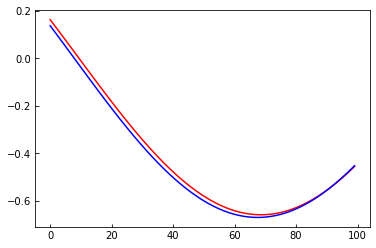

In [36]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0, 272)
plt.plot(spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, 0, :], "b")
print(params[rand])


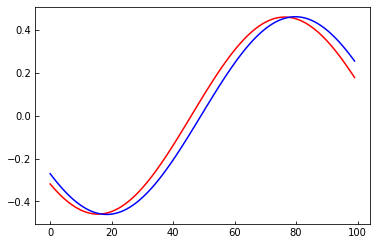

In [37]:
nala_spectra_generated, nala_params = model(nala_spectra.transpose(2, 1).cuda())
rand = np.random.randint(0, nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(nala_spectra[rand, :, 0], "b")


In [38]:
# removes 2pi shifts
nala_params[:, 1] = nala_params[:, 1] % 2 * np.pi


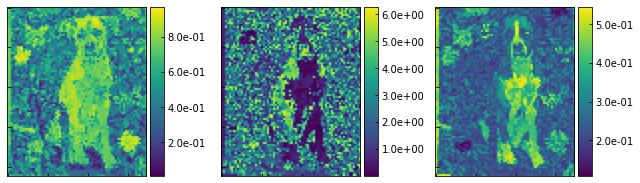

In [39]:
# Visualize the learned embeddings

embedding_maps(nala_params.detach().cpu().numpy(), image)

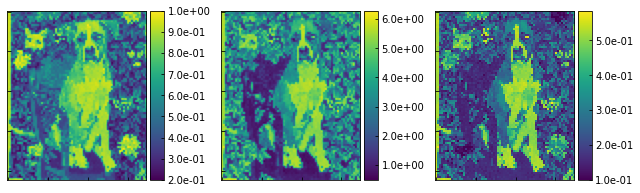

In [40]:
# visualize the actual RGB channels.

embedding_maps(_nala_params.reshape(-1, 3), image)


- **results are much closer to the underlying physics since we enforced them**
- The middle parameter is the phase. This is the hardest to learn $\rightarrow$ this makes sense


## Try with a better optimizer AdaHessian

- There are better optimizers than ADAM that use second-order information


In [41]:
"""
Created on Sun Feb 26 16:34:00 2021
@author: Amir Gholami
@coauthor: David Samuel
"""

import numpy as np
import torch


class AdaHessian(torch.optim.Optimizer):
    """
    Implements the AdaHessian algorithm from "ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning"
    Arguments:
        params (iterable) -- iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional) -- learning rate (default: 0.1)
        betas ((float, float), optional) -- coefficients used for computing running averages of gradient and the squared hessian trace (default: (0.9, 0.999))
        eps (float, optional) -- term added to the denominator to improve numerical stability (default: 1e-8)
        weight_decay (float, optional) -- weight decay (L2 penalty) (default: 0.0)
        hessian_power (float, optional) -- exponent of the hessian trace (default: 1.0)
        update_each (int, optional) -- compute the hessian trace approximation only after *this* number of steps (to save time) (default: 1)
        n_samples (int, optional) -- how many times to sample `z` for the approximation of the hessian trace (default: 1)
    """

    def __init__(
        self,
        params,
        lr=0.1,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0.0,
        hessian_power=1.0,
        update_each=1,
        n_samples=1,
        average_conv_kernel=False,
    ):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError(f"Invalid Hessian power value: {hessian_power}")

        self.n_samples = n_samples
        self.update_each = update_each
        self.average_conv_kernel = average_conv_kernel

        # use a separate generator that deterministically generates the same `z`s across all GPUs in case of distributed training
        self.generator = torch.Generator().manual_seed(2147483647)

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            hessian_power=hessian_power,
        )
        super(AdaHessian, self).__init__(params, defaults)

        for p in self.get_params():
            p.hess = 0.0
            self.state[p]["hessian step"] = 0

    def get_params(self):
        """
        Gets all parameters in all param_groups with gradients
        """

        return (
            p for group in self.param_groups for p in group["params"] if p.requires_grad
        )

    def zero_hessian(self):
        """
        Zeros out the accumulated hessian traces.
        """

        for p in self.get_params():
            if (
                not isinstance(p.hess, float)
                and self.state[p]["hessian step"] % self.update_each == 0
            ):
                p.hess.zero_()

    @torch.no_grad()
    def set_hessian(self):
        """
        Computes the Hutchinson approximation of the hessian trace and accumulates it for each trainable parameter.
        """

        params = []
        for p in filter(lambda p: p.grad is not None, self.get_params()):
            if (
                self.state[p]["hessian step"] % self.update_each == 0
            ):  # compute the trace only for each `update_each` step
                params.append(p)
            self.state[p]["hessian step"] += 1

        if len(params) == 0:
            return

        if (
            self.generator.device != params[0].device
        ):  # hackish way of casting the generator to the right device
            self.generator = torch.Generator(params[0].device).manual_seed(2147483647)

        grads = [p.grad for p in params]

        for i in range(self.n_samples):
            zs = [
                torch.randint(0, 2, p.size(), generator=self.generator, device=p.device)
                * 2.0
                - 1.0
                for p in params
            ]  # Rademacher distribution {-1.0, 1.0}
            h_zs = torch.autograd.grad(
                grads,
                params,
                grad_outputs=zs,
                only_inputs=True,
                retain_graph=i < self.n_samples - 1,
            )
            for h_z, z, p in zip(h_zs, zs, params):
                p.hess += (
                    h_z * z / self.n_samples
                )  # approximate the expected values of z*(H@z)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional) -- a closure that reevaluates the model and returns the loss (default: None)
        """

        loss = None
        if closure is not None:
            loss = closure()

        self.zero_hessian()
        self.set_hessian()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or p.hess is None:
                    continue

                if self.average_conv_kernel and p.dim() == 4:
                    p.hess = (
                        torch.abs(p.hess)
                        .mean(dim=[2, 3], keepdim=True)
                        .expand_as(p.hess)
                        .clone()
                    )

                # Perform correct stepweight decay as in AdamW
                p.mul_(1 - group["lr"] * group["weight_decay"])

                state = self.state[p]

                # State initialization
                if len(state) == 1:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(
                        p.data
                    )  # Exponential moving average of gradient values
                    state["exp_hessian_diag_sq"] = torch.zeros_like(
                        p.data
                    )  # Exponential moving average of Hessian diagonal square values

                exp_avg, exp_hessian_diag_sq = (
                    state["exp_avg"],
                    state["exp_hessian_diag_sq"],
                )
                beta1, beta2 = group["betas"]
                state["step"] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_hessian_diag_sq.mul_(beta2).addcmul_(
                    p.hess, p.hess, value=1 - beta2
                )

                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]

                k = group["hessian_power"]
                denom = (
                    (exp_hessian_diag_sq / bias_correction2)
                    .pow_(k / 2)
                    .add_(group["eps"])
                )

                # make update
                step_size = group["lr"] / bias_correction1
                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

### Builds the model


In [42]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(
    x_vector, constructor, dense_params=3, model_params=3, verbose=False
)

if torch.cuda.is_available():
    model.cuda()

### Dataloader


In [43]:
# builds the dataloader

dataloader = DataLoader(
    torch.transpose(spectra_full, 1, 2), batch_size=512, shuffle=True, num_workers=0
)

### Training


In [44]:
set_seeds(42)

loss_func = torch.nn.MSELoss()

# Use AdaHessian

optimizer = AdaHessian(model.parameters(), lr=0.1)

epochs = 200

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in dataloader:
        pred, _ = model(train_batch.cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))

epoch : 0/200, recon loss = 0.14622953
--- 1.0883708000183105 seconds ---


epoch : 1/200, recon loss = 0.08870444
--- 1.0893378257751465 seconds ---


epoch : 2/200, recon loss = 0.07115541
--- 1.0838940143585205 seconds ---


epoch : 3/200, recon loss = 0.06154701
--- 1.0916635990142822 seconds ---


epoch : 4/200, recon loss = 0.05499031
--- 1.0354487895965576 seconds ---


epoch : 5/200, recon loss = 0.04892037
--- 1.0424182415008545 seconds ---


epoch : 6/200, recon loss = 0.04381424
--- 1.0579235553741455 seconds ---


epoch : 7/200, recon loss = 0.03949650
--- 1.0890934467315674 seconds ---


epoch : 8/200, recon loss = 0.03563823
--- 1.0884504318237305 seconds ---


epoch : 9/200, recon loss = 0.03284716
--- 1.0835583209991455 seconds ---


epoch : 10/200, recon loss = 0.03032054
--- 1.0858421325683594 seconds ---


epoch : 11/200, recon loss = 0.02864386
--- 1.0839331150054932 seconds ---


epoch : 12/200, recon loss = 0.02732523
--- 1.069594144821167 seconds ---


epoch : 13/200, recon loss = 0.02589927
--- 1.0777921676635742 seconds ---


epoch : 14/200, recon loss = 0.02507744
--- 1.0799477100372314 seconds ---


epoch : 15/200, recon loss = 0.02416596
--- 1.037599802017212 seconds ---


epoch : 16/200, recon loss = 0.02339337
--- 1.0292999744415283 seconds ---


epoch : 17/200, recon loss = 0.02263889
--- 1.0340898036956787 seconds ---


epoch : 18/200, recon loss = 0.02200026
--- 1.119666576385498 seconds ---


epoch : 19/200, recon loss = 0.02124349
--- 1.0820939540863037 seconds ---


epoch : 20/200, recon loss = 0.02075389
--- 1.1650669574737549 seconds ---


epoch : 21/200, recon loss = 0.02009582
--- 1.296419382095337 seconds ---


epoch : 22/200, recon loss = 0.01971562
--- 1.1253688335418701 seconds ---


epoch : 23/200, recon loss = 0.01918470
--- 1.1135249137878418 seconds ---


epoch : 24/200, recon loss = 0.01898377
--- 1.103553056716919 seconds ---


epoch : 25/200, recon loss = 0.01820066
--- 1.101011037826538 seconds ---


epoch : 26/200, recon loss = 0.01802140
--- 1.0970237255096436 seconds ---


epoch : 27/200, recon loss = 0.01828356
--- 1.1360204219818115 seconds ---


epoch : 28/200, recon loss = 0.01755643
--- 1.1145133972167969 seconds ---


epoch : 29/200, recon loss = 0.01712156
--- 1.1235291957855225 seconds ---


epoch : 30/200, recon loss = 0.01667318
--- 1.1050267219543457 seconds ---


epoch : 31/200, recon loss = 0.01653478
--- 1.111032485961914 seconds ---


epoch : 32/200, recon loss = 0.01657444
--- 1.071531057357788 seconds ---


epoch : 33/200, recon loss = 0.01612311
--- 1.037576675415039 seconds ---


epoch : 34/200, recon loss = 0.01569985
--- 1.085510015487671 seconds ---


epoch : 35/200, recon loss = 0.01525746
--- 1.1070287227630615 seconds ---


epoch : 36/200, recon loss = 0.01487744
--- 1.1145381927490234 seconds ---


epoch : 37/200, recon loss = 0.01476719
--- 1.1015546321868896 seconds ---


epoch : 38/200, recon loss = 0.01453862
--- 1.106942892074585 seconds ---


epoch : 39/200, recon loss = 0.01423899
--- 1.10652756690979 seconds ---


epoch : 40/200, recon loss = 0.01407445
--- 1.1225273609161377 seconds ---


epoch : 41/200, recon loss = 0.01397197
--- 1.101017713546753 seconds ---


epoch : 42/200, recon loss = 0.01365025
--- 1.0595316886901855 seconds ---


epoch : 43/200, recon loss = 0.01342940
--- 1.051011562347412 seconds ---


epoch : 44/200, recon loss = 0.01352517
--- 1.112027883529663 seconds ---


epoch : 45/200, recon loss = 0.01313578
--- 1.113030195236206 seconds ---


epoch : 46/200, recon loss = 0.01285403
--- 1.1130003929138184 seconds ---


epoch : 47/200, recon loss = 0.01303013
--- 1.1230175495147705 seconds ---


epoch : 48/200, recon loss = 0.01242629
--- 1.0965216159820557 seconds ---


epoch : 49/200, recon loss = 0.01224407
--- 1.1120336055755615 seconds ---


epoch : 50/200, recon loss = 0.01223961
--- 1.1120188236236572 seconds ---


epoch : 51/200, recon loss = 0.01178110
--- 1.1128785610198975 seconds ---


epoch : 52/200, recon loss = 0.01140020
--- 1.1110155582427979 seconds ---


epoch : 53/200, recon loss = 0.01137775
--- 1.1300475597381592 seconds ---


epoch : 54/200, recon loss = 0.01137667
--- 1.0320117473602295 seconds ---


epoch : 55/200, recon loss = 0.01113453
--- 1.0290005207061768 seconds ---


epoch : 56/200, recon loss = 0.01096199
--- 1.0180001258850098 seconds ---


epoch : 57/200, recon loss = 0.01062950
--- 1.0389988422393799 seconds ---


epoch : 58/200, recon loss = 0.01048227
--- 1.0230014324188232 seconds ---


epoch : 59/200, recon loss = 0.01038954
--- 1.0220003128051758 seconds ---


epoch : 60/200, recon loss = 0.01021639
--- 1.0209991931915283 seconds ---


epoch : 61/200, recon loss = 0.01008049
--- 1.017000675201416 seconds ---


epoch : 62/200, recon loss = 0.01007335
--- 1.0179989337921143 seconds ---


epoch : 63/200, recon loss = 0.01021946
--- 1.0109999179840088 seconds ---


epoch : 64/200, recon loss = 0.01001099
--- 1.014000415802002 seconds ---


epoch : 65/200, recon loss = 0.00975303
--- 1.0109994411468506 seconds ---


epoch : 66/200, recon loss = 0.00959877
--- 1.013000249862671 seconds ---


epoch : 67/200, recon loss = 0.00973860
--- 1.0179996490478516 seconds ---


epoch : 68/200, recon loss = 0.00968166
--- 1.0230002403259277 seconds ---


epoch : 69/200, recon loss = 0.00953017
--- 1.0210011005401611 seconds ---


epoch : 70/200, recon loss = 0.00943276
--- -23.747867584228516 seconds ---


epoch : 71/200, recon loss = 0.00957313
--- 1.0489978790283203 seconds ---


epoch : 72/200, recon loss = 0.00908536
--- 1.0200014114379883 seconds ---


epoch : 73/200, recon loss = 0.00911939
--- 1.0295078754425049 seconds ---


epoch : 74/200, recon loss = 0.00889253
--- 1.029998540878296 seconds ---


epoch : 75/200, recon loss = 0.00909467
--- 1.0439996719360352 seconds ---


epoch : 76/200, recon loss = 0.00912187
--- 1.0410008430480957 seconds ---


epoch : 77/200, recon loss = 0.00879111
--- 1.0209999084472656 seconds ---


epoch : 78/200, recon loss = 0.00851757
--- 1.0400004386901855 seconds ---


epoch : 79/200, recon loss = 0.00846356
--- 1.0199997425079346 seconds ---


epoch : 80/200, recon loss = 0.00851532
--- 1.0250000953674316 seconds ---


epoch : 81/200, recon loss = 0.00846477
--- 1.0129992961883545 seconds ---


epoch : 82/200, recon loss = 0.00806178
--- 1.010000467300415 seconds ---


epoch : 83/200, recon loss = 0.00808763
--- 1.0190000534057617 seconds ---


epoch : 84/200, recon loss = 0.00811538
--- 1.0159993171691895 seconds ---


epoch : 85/200, recon loss = 0.00813273
--- 1.0129997730255127 seconds ---


epoch : 86/200, recon loss = 0.00796679
--- 1.0070011615753174 seconds ---


epoch : 87/200, recon loss = 0.00801457
--- 1.0099995136260986 seconds ---


epoch : 88/200, recon loss = 0.00819638
--- 1.0220015048980713 seconds ---


epoch : 89/200, recon loss = 0.00779455
--- 1.0109989643096924 seconds ---


epoch : 90/200, recon loss = 0.00778407
--- 1.0159993171691895 seconds ---


epoch : 91/200, recon loss = 0.00772507
--- 1.0189998149871826 seconds ---


epoch : 92/200, recon loss = 0.00784953
--- 1.0149993896484375 seconds ---


epoch : 93/200, recon loss = 0.00777986
--- 1.0170013904571533 seconds ---


epoch : 94/200, recon loss = 0.00779847
--- 1.0219998359680176 seconds ---


epoch : 95/200, recon loss = 0.00779865
--- 1.0205085277557373 seconds ---


epoch : 96/200, recon loss = 0.00918717
--- 1.016012191772461 seconds ---


epoch : 97/200, recon loss = 0.00825832
--- 1.017012119293213 seconds ---


epoch : 98/200, recon loss = 0.00800006
--- 1.0169239044189453 seconds ---


epoch : 99/200, recon loss = 0.00750945
--- 1.0162386894226074 seconds ---


epoch : 100/200, recon loss = 0.00753495
--- 1.0279994010925293 seconds ---


epoch : 101/200, recon loss = 0.00841109
--- 1.0252225399017334 seconds ---


epoch : 102/200, recon loss = 0.00752582
--- 1.022576093673706 seconds ---


epoch : 103/200, recon loss = 0.00722907
--- 1.0390236377716064 seconds ---


epoch : 104/200, recon loss = 0.00746055
--- 1.034031629562378 seconds ---


epoch : 105/200, recon loss = 0.00766218
--- 1.0347788333892822 seconds ---


epoch : 106/200, recon loss = 0.00718742
--- 1.0392041206359863 seconds ---


epoch : 107/200, recon loss = 0.00677364
--- 1.0289995670318604 seconds ---


epoch : 108/200, recon loss = 0.00688360
--- 1.031905174255371 seconds ---


epoch : 109/200, recon loss = 0.00680055
--- 1.029261589050293 seconds ---


epoch : 110/200, recon loss = 0.00674870
--- 1.0260009765625 seconds ---


epoch : 111/200, recon loss = 0.00680350
--- 1.0299737453460693 seconds ---


epoch : 112/200, recon loss = 0.00657709
--- 1.025000810623169 seconds ---


epoch : 113/200, recon loss = 0.00677112
--- 1.03056001663208 seconds ---


epoch : 114/200, recon loss = 0.00711633
--- 1.043140172958374 seconds ---


epoch : 115/200, recon loss = 0.00683655
--- 1.0489990711212158 seconds ---


epoch : 116/200, recon loss = 0.00695028
--- 1.024001121520996 seconds ---


epoch : 117/200, recon loss = 0.00700970
--- 1.017998218536377 seconds ---


epoch : 118/200, recon loss = 0.00646159
--- 1.0270001888275146 seconds ---


epoch : 119/200, recon loss = 0.00626498
--- 1.0400028228759766 seconds ---


epoch : 120/200, recon loss = 0.00638640
--- 1.0209972858428955 seconds ---


epoch : 121/200, recon loss = 0.00694084
--- 1.0240018367767334 seconds ---


epoch : 122/200, recon loss = 0.00717964
--- 1.0299999713897705 seconds ---


epoch : 123/200, recon loss = 0.00649016
--- 1.0209989547729492 seconds ---


epoch : 124/200, recon loss = 0.00610821
--- 1.024000644683838 seconds ---


epoch : 125/200, recon loss = 0.00618191
--- 1.0259997844696045 seconds ---


epoch : 126/200, recon loss = 0.00608647
--- 1.0239994525909424 seconds ---


epoch : 127/200, recon loss = 0.00611387
--- 1.0200004577636719 seconds ---


epoch : 128/200, recon loss = 0.00606591
--- 1.0230002403259277 seconds ---


epoch : 129/200, recon loss = 0.00615202
--- 1.0269997119903564 seconds ---


epoch : 130/200, recon loss = 0.00602813
--- 1.0209999084472656 seconds ---


epoch : 131/200, recon loss = 0.00603375
--- 1.0250003337860107 seconds ---


epoch : 132/200, recon loss = 0.00612670
--- 1.0230000019073486 seconds ---


epoch : 133/200, recon loss = 0.00599917
--- 1.0169992446899414 seconds ---


epoch : 134/200, recon loss = 0.00579245
--- 1.0220005512237549 seconds ---


epoch : 135/200, recon loss = 0.00577826
--- 1.0270006656646729 seconds ---


epoch : 136/200, recon loss = 0.00610074
--- 1.0189990997314453 seconds ---


epoch : 137/200, recon loss = 0.00594414
--- 1.0210003852844238 seconds ---


epoch : 138/200, recon loss = 0.00582040
--- 1.0180003643035889 seconds ---


epoch : 139/200, recon loss = 0.00588212
--- 1.032999038696289 seconds ---


epoch : 140/200, recon loss = 0.00576247
--- 1.0239994525909424 seconds ---


epoch : 141/200, recon loss = 0.00622758
--- 1.0140008926391602 seconds ---


epoch : 142/200, recon loss = 0.00606107
--- 1.0159988403320312 seconds ---


epoch : 143/200, recon loss = 0.00619729
--- 1.0250015258789062 seconds ---


epoch : 144/200, recon loss = 0.00573270
--- 1.0260000228881836 seconds ---


epoch : 145/200, recon loss = 0.00586529
--- 1.0210001468658447 seconds ---


epoch : 146/200, recon loss = 0.00571225
--- 1.025998592376709 seconds ---


epoch : 147/200, recon loss = 0.00540349
--- 1.0340015888214111 seconds ---


epoch : 148/200, recon loss = 0.00534166
--- 1.022998332977295 seconds ---


epoch : 149/200, recon loss = 0.00537172
--- 1.0330009460449219 seconds ---


epoch : 150/200, recon loss = 0.00517132
--- 1.0269997119903564 seconds ---


epoch : 151/200, recon loss = 0.00516037
--- 1.0210003852844238 seconds ---


epoch : 152/200, recon loss = 0.00517982
--- 1.0170001983642578 seconds ---


epoch : 153/200, recon loss = 0.00514973
--- 1.0180003643035889 seconds ---


epoch : 154/200, recon loss = 0.00524550
--- 1.0339992046356201 seconds ---


epoch : 155/200, recon loss = 0.00518284
--- 1.0230004787445068 seconds ---


epoch : 156/200, recon loss = 0.00515754
--- 1.0260000228881836 seconds ---


epoch : 157/200, recon loss = 0.00503706
--- 1.021998643875122 seconds ---


epoch : 158/200, recon loss = 0.00500842
--- 1.018000602722168 seconds ---


epoch : 159/200, recon loss = 0.00504427
--- 1.024000644683838 seconds ---


epoch : 160/200, recon loss = 0.00503538
--- 1.0209999084472656 seconds ---


epoch : 161/200, recon loss = 0.00519382
--- 1.0169999599456787 seconds ---


epoch : 162/200, recon loss = 0.00501423
--- 1.0160002708435059 seconds ---


epoch : 163/200, recon loss = 0.00484444
--- 1.0199999809265137 seconds ---


epoch : 164/200, recon loss = 0.00480152
--- 1.0159997940063477 seconds ---


epoch : 165/200, recon loss = 0.00496122
--- 1.0169999599456787 seconds ---


epoch : 166/200, recon loss = 0.00497636
--- 1.0250003337860107 seconds ---


epoch : 167/200, recon loss = 0.00490355
--- 1.0189993381500244 seconds ---


epoch : 168/200, recon loss = 0.00474834
--- 1.0290005207061768 seconds ---


epoch : 169/200, recon loss = 0.00474437
--- 1.0260188579559326 seconds ---


epoch : 170/200, recon loss = 0.00464632
--- 1.0219807624816895 seconds ---


epoch : 171/200, recon loss = 0.00498418
--- 1.0525057315826416 seconds ---


epoch : 172/200, recon loss = 0.00489927
--- 1.0439999103546143 seconds ---


epoch : 173/200, recon loss = 0.00463136
--- 1.036999225616455 seconds ---


epoch : 174/200, recon loss = 0.00463337
--- 1.0480000972747803 seconds ---


epoch : 175/200, recon loss = 0.00461542
--- 1.054999589920044 seconds ---


epoch : 176/200, recon loss = 0.00467008
--- 1.0430009365081787 seconds ---


epoch : 177/200, recon loss = 0.00490815
--- 1.055999994277954 seconds ---


epoch : 178/200, recon loss = 0.00477646
--- 1.024000883102417 seconds ---


epoch : 179/200, recon loss = 0.00450615
--- 1.0209996700286865 seconds ---


epoch : 180/200, recon loss = 0.00446758
--- 1.0210011005401611 seconds ---


epoch : 181/200, recon loss = 0.00478158
--- 1.016998052597046 seconds ---


epoch : 182/200, recon loss = 0.00450005
--- 1.025001049041748 seconds ---


epoch : 183/200, recon loss = 0.00455204
--- 1.0200004577636719 seconds ---


epoch : 184/200, recon loss = 0.00441376
--- 1.0189988613128662 seconds ---


epoch : 185/200, recon loss = 0.00441344
--- 1.02000093460083 seconds ---


epoch : 186/200, recon loss = 0.00465882
--- 1.0179994106292725 seconds ---


epoch : 187/200, recon loss = 0.00467695
--- 1.0200002193450928 seconds ---


epoch : 188/200, recon loss = 0.00444127
--- 1.0270006656646729 seconds ---


epoch : 189/200, recon loss = 0.00434032
--- 1.0409996509552002 seconds ---


epoch : 190/200, recon loss = 0.00428995
--- 1.0199992656707764 seconds ---


epoch : 191/200, recon loss = 0.00429754
--- 1.0270006656646729 seconds ---


epoch : 192/200, recon loss = 0.00457829
--- 1.0379998683929443 seconds ---


epoch : 193/200, recon loss = 0.00451110
--- 1.0219995975494385 seconds ---


epoch : 194/200, recon loss = 0.00422032
--- 1.0300006866455078 seconds ---


epoch : 195/200, recon loss = 0.00419769
--- 1.0229997634887695 seconds ---


epoch : 196/200, recon loss = 0.00434486
--- 1.0259995460510254 seconds ---


epoch : 197/200, recon loss = 0.00435393
--- 1.0220003128051758 seconds ---


epoch : 198/200, recon loss = 0.00415369
--- 1.0360007286071777 seconds ---


epoch : 199/200, recon loss = 0.00415558
--- 1.0159993171691895 seconds ---


### Visualization


tensor([0.6948, 2.9968, 0.1354], device='cuda:0', grad_fn=<SelectBackward0>)


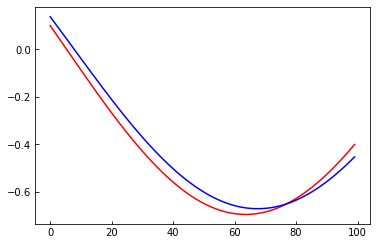

In [45]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0, 272)
plt.plot(spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, 0, :], "b")
print(params[rand])


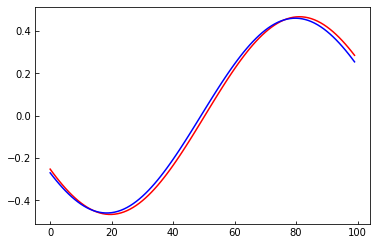

In [46]:
nala_spectra_generated, nala_params = model(nala_spectra.transpose(2, 1).cuda())
rand = np.random.randint(0, nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(nala_spectra[rand, :, 0], "b")


In [47]:
nala_params[:, 1] = nala_params[:, 1] % 2 * np.pi


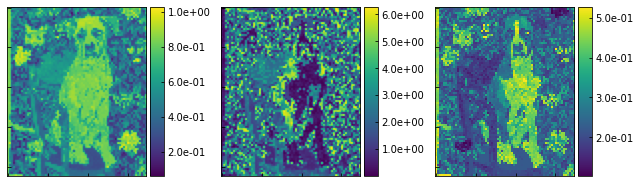

In [48]:
# Visualize the learned embeddings

embedding_maps(nala_params.detach().cpu().numpy(), image)

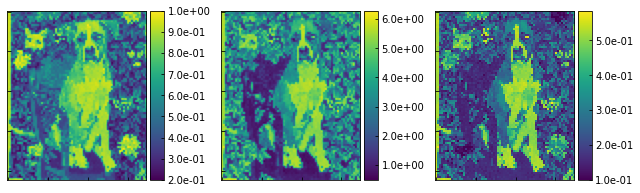

In [49]:
# visualize the actual RGB channels.

embedding_maps(_nala_params.reshape(-1, 3), image)


This is clearly the best result

- It is quite impressive that we can build a feed forward model to fit data to complex functions
- This is actually a very hard task for a neural network as frequency and phase are something that cannot be learned easily in convolutions
